# MBML project: Modelling COVID-19 

**Group members:** *Anders Nikolai Fure Nielsen (s192288)*, *Daniel Juhász Vigild (s161749), Jonas Søbro Christophersen (s153232) & Lau Johansson (s164512)* <br>
**Date:** 30th May 2020


#Project scope

While people all across the world are affected by the spread of COVID-19, scientist are trying to learn more about what laws governs the dynamics of virus spread. The basic dynamics are well known (we have all seen the "flattening the curve"-visualization), but it is clear that the virus has spread in different ways in different parts of the world, or even in different parts of the same countries. It seems that demographics and peoples behaviour impact the spread of the virus in a profound way. [This can be seen in USA, where black communities are disproportionately affected by the virus](https://www.npr.org/sections/coronavirus-live-updates/2020/04/10/832039813/why-misinformation-and-distrust-is-making-covid-19-more-dangerous-for-black-amer?t=1587908515127), or in northern Italy where a cocktail of an aging demographics along with the behaviour of ski-tourists in the Alpes created a new virus epicenter outside of China. 
<br>
<br>
This project sets out to model the deaths of COVID-19 using confirmed and death statistics, along with a plethora of external covariates from the Google Mobility Report and OECD-database. From this we hope to **learn more about what impacts the deaths of the virus and to what degree it impacts the deaths - in an effort to gain insight into what measures should be taken so the world is better prepared for the next pandemic**. Along the way, we will also explore models that should be able to **predict COVID-19 related deaths with an acceptable accuracy**.

##Imports and mount drive

In [0]:
!pip install numpyro
import numpy as np
import pandas as pd
import io
import datetime as datetime
import requests
from numpyro.infer import Predictive
from google.colab import drive
from matplotlib import pyplot as plt
import seaborn as sns
import time
from matplotlib import pyplot as plt
import time
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Data processing

This section collects and combines the three data sets which are to be analyzed. The data sets can be found at the following links:

[COVID-19 Data](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)

[OECD Data](https://stats.oecd.org/)

[Google Mobility Report Data](https://www.google.com/covid19/mobility/)

**Disclaimer: The data-gathering is done in real-time, therefore if you run this notebook yourself, the data (and results) will be different as compared to the rendered version (which was done on May 30th 2020).**

As we know there is a time-delay between changes in peoples behavioural patterns and its effect on COVID-19 cases (both confirmed cases and deaths) the google mobility data is lagged to compensate for this. As data for COVID-19 cases are reported differently for different countries and there isn't a lot of data available since the time series is relatively short it is hard to analytically determine what this time-delay might be. The average incubation time for COVID-19 is [5 days](https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200402-sitrep-73-covid-19.pdf?sfvrsn=5ae25bc7_4). The average time-delay between shown symptoms and death is [18 days](https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext) and thus the behavioural data is shifted 23 time-steps to account for this delay when modelling COVID-19 deaths. For the purpose of this project, the confirmed cases are lagged 14 days since we assume a few days time-delay where people show symtoms (at home) but have not yet gone to get tested.

As interpretability is valued highly in this project, we have chosen not to standardize the data used in modelling.

In [0]:
# OECD data is preprocessed in a local python-script but is presented in a future section.
df_oecd = pd.read_csv('/content/drive/My Drive/Modelbased ML Project/OECD_data.csv')

timeseries = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv", sep = ",")
confirmed = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
recoverd = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

timeseries_temp = timeseries.groupby("Country/Region").sum()
timeseries_temp = timeseries_temp.drop(columns=["Long","Lat"])

conf_temp = confirmed.groupby("Country/Region").sum()
conf_temp = conf_temp.drop(columns=["Long","Lat"])

rec_temp = recoverd.groupby("Country/Region").sum()
rec_temp = rec_temp.drop(columns=["Long","Lat"])

# Make a list of the dates
start = datetime.datetime.strptime("22-01-2020", "%d-%m-%Y")
end = datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
date_list = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

cases_list = timeseries_temp.iloc[0,:].values  # Grab cases
conf_list = conf_temp.iloc[0,:].values  # Grab confirmed
rec_list = rec_temp.iloc[0,:].values

country = timeseries_temp.iloc[0].name   # Get name of country
country_list = [country] * len(cases_list) # get them as list

# Create DataFrame 
df = pd.DataFrame({"Country":country_list, 
                         "Death":cases_list,
                        "Confirmed":conf_list,
                        "Recovered":rec_list,
                         "Date":date_list}) 

for k in range(1,len(timeseries_temp)):   
  
    cases_list = timeseries_temp.iloc[k,:].values  # Grab cases
    conf_list = conf_temp.iloc[k,:].values  # Grab confirmed
    rec_list = rec_temp.iloc[k,:].values
    
    country = timeseries_temp.iloc[k].name   # Get name of country
    country_list = [country] * len(cases_list) # get them as list
    
    df2 = pd.DataFrame({"Country":country_list, 
                         "Death":cases_list,
                        "Confirmed":conf_list,
                        "Recovered":rec_list,
                         "Date":date_list}) 
    df = df.append(df2) 

df = df.reset_index(drop=True)

df_covid = df

Change from accumulated to cases-per-day

In [0]:
df_covid["DeathAccumulated"] = df_covid["Death"]
df_covid["ConfirmedAccumulated"] = df_covid["Confirmed"]
df_covid["RecoveredAccumulated"] = df_covid["Recovered"]

In [0]:
countries = np.unique(df_covid.Country)

In [0]:
for country in countries:
  deathcases =  (df_covid[df_covid["Country"] == country]["DeathAccumulated"] - (df_covid[df_covid["Country"] == country]["DeathAccumulated"]).shift(1))
  df_covid["Death"].iloc[deathcases.index] = deathcases
  
  confirmedcases =  (df_covid[df_covid["Country"] == country]["ConfirmedAccumulated"] - (df_covid[df_covid["Country"] == country]["ConfirmedAccumulated"]).shift(1))
  df_covid["Confirmed"].iloc[deathcases.index] = confirmedcases
 
  recoveredcases =  (df_covid[df_covid["Country"] == country]["RecoveredAccumulated"] - (df_covid[df_covid["Country"] == country]["RecoveredAccumulated"]).shift(1))
  df_covid["Recovered"].iloc[deathcases.index] = recoveredcases

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
df_covid = df_covid.dropna()
df_covid.reset_index(drop=True)

Country  Death  ...  ConfirmedAccumulated  RecoveredAccumulated
0      Afghanistan    0.0  ...                     0                     0
1      Afghanistan    0.0  ...                     0                     0
2      Afghanistan    0.0  ...                     0                     0
3      Afghanistan    0.0  ...                     0                     0
4      Afghanistan    0.0  ...                     0                     0
...            ...    ...  ...                   ...                   ...
24059     Zimbabwe    0.0  ...                    56                    25
24060     Zimbabwe    0.0  ...                    56                    25
24061     Zimbabwe    0.0  ...                   132                    25
24062     Zimbabwe    0.0  ...                   149                    28
24063     Zimbabwe    0.0  ...                   149                    28

[24064 rows x 8 columns]

In [0]:
# Get realtime google mobility data
url="https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv"
s=requests.get(url).content
df_trends=pd.read_csv(io.StringIO(s.decode('utf-8')))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
df_trends.head()

country_region_code  ... residential_percent_change_from_baseline
0                  AE  ...                                      1.0
1                  AE  ...                                      1.0
2                  AE  ...                                      1.0
3                  AE  ...                                      1.0
4                  AE  ...                                      1.0

[5 rows x 11 columns]

Remove white-spaces

In [0]:
df_oecd = df_oecd.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df_trends = df_trends.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [0]:
df_oecd.head(5)

LOCATION    Country  ...  Number of people per household  Single person households
0      AUS  Australia  ...                           2.558                       NaN
1      AUS  Australia  ...                           2.558                       NaN
2      AUS  Australia  ...                           2.558                       NaN
3      AUS  Australia  ...                           2.558                       NaN
4      AUS  Australia  ...                           2.558                       NaN

[5 rows x 18 columns]

In [0]:
df_trends.head(5)

country_region_code  ... residential_percent_change_from_baseline
0                  AE  ...                                      1.0
1                  AE  ...                                      1.0
2                  AE  ...                                      1.0
3                  AE  ...                                      1.0
4                  AE  ...                                      1.0

[5 rows x 11 columns]

In [0]:
df_trends["Country"] = df_trends["country_region"]
df_trends_group = df_trends.groupby(["Country", "date"]).mean() ## Mean across regions
df_trends_final = pd.DataFrame(df_trends_group.to_records())

In [0]:
# Select highest year values in df_oecd to get most recent data
df_oecd_recent = pd.DataFrame(columns = df_oecd.columns)
uniquecountries = np.unique(df_oecd.Country)
for country in uniquecountries:
  onecountry = df_oecd[df_oecd["Country"] == country]
  onecountry_maxyear = onecountry[onecountry["Year"] == np.max(onecountry["Year"].values)]
  df_oecd_recent = df_oecd_recent.append(onecountry_maxyear) 

In [0]:
df_oecd_recent = df_oecd_recent.reset_index(drop =True)

In [0]:
df_oecd_recent.head()

LOCATION    Country  ... Number of people per household Single person households
0      AUS  Australia  ...                          2.558                      NaN
1      AUT    Austria  ...                          2.200                   36.289
2      BEL    Belgium  ...                          2.400                   34.060
3      BRA     Brazil  ...                            NaN                      NaN
4      CAN     Canada  ...                          2.467                      NaN

[5 rows x 18 columns]

In [0]:
# Add a variable that counts 65-80 age of people, so the two variables 65+ and 80+ are not sharing data.
df_oecd_recent["Population__65_to_80_years_old"] = df_oecd_recent["Population__65_years_old_and_over"] - df_oecd_recent["Population__80_years_old_and_over"] 

In [0]:
# Merge the oecd data with the google trends on country-level
mer = pd.merge(df_trends_final, df_oecd_recent, on = "Country", how = "inner")

In [0]:
np.unique(mer['Country']) # this is the unique list of countries which have data available

array(['Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Chile',
       'Colombia', 'Costa Rica', 'Denmark', 'Estonia', 'Finland',
       'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Israel',
       'Italy', 'Japan', 'Latvia', 'Lithuania', 'Luxembourg', 'Mexico',
       'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal',
       'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland',
       'Turkey', 'United Kingdom', 'United States'], dtype=object)

In [0]:
df_covid["Date"]
mer["Date"] = pd.to_datetime(mer["date"])

In [0]:
df_covid.head(3)

Country  Death  ...  ConfirmedAccumulated  RecoveredAccumulated
1  Afghanistan    0.0  ...                     0                     0
2  Afghanistan    0.0  ...                     0                     0
3  Afghanistan    0.0  ...                     0                     0

[3 rows x 8 columns]

In [0]:
mer["Country"] = mer["Country"].astype(str)
df_covid["Country"] = df_covid["Country"].astype(str)
mer["Date"] = mer["Date"].astype(str)
df_covid["Date"] = df_covid["Date"].astype(str)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
covidandmer = pd.merge(df_covid, mer,  how='inner', on = ["Date", "Country"])
covidandmer = covidandmer.drop(columns=["date"])
#covidandmer[covidandmer["Country"] == "Denmark"][43:]

### Shift and add external timerelated variables according to highest auto correlation with confirmed and deaths

In [0]:
changesfrombaseline = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']

In [0]:
# Add lagged versions to dataset
for variable in changesfrombaseline:
  name = variable + "_Lag_" + str(int(23))
  covidandmer[name] = covidandmer[variable].shift(periods = int(23))

# Lag confirmed cases to model deaths
name = "Confirmed" + "_Lag_" + str(int(14))
covidandmer[name] = covidandmer["Confirmed"].shift(periods = int(14))

In [0]:
# Save the data in a csv
covidandmer.to_csv('/content/drive/My Drive/Modelbased ML Project/covid_and_externalvars.csv')

In [0]:
# Select just europe-countries
europe = covidandmer[covidandmer['Country'].isin(['Austria', 'Denmark', 'Estonia', 'Finland',
       'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
       'Italy', 'Latvia', 'Lithuania', 'Luxembourg',
       'Netherlands', 'Norway', 'Poland', 'Portugal',
       'Slovenia', 'Spain', 'Sweden', 'Switzerland',
       'United Kingdom', 'Belgium'])]
       
europe = europe.reset_index(drop=True)
europe.to_csv('/content/drive/My Drive/Modelbased ML Project/covid_and_externalvars_europe.csv')
europe_deatht0 = europe.copy(deep=True)

In [0]:
# Get names of indexes for which column Death has value 0
indexNames = europe[europe['Death'] == 0 ].index
# Delete these row indexes from dataFrame
europe_deatht0.drop(indexNames , inplace=True)

In [0]:
# Remove countries that do not have enough data as these "block" the data available for the remaining countries
europe_deatht0_lesscountries = europe_deatht0.copy(deep=True)
countryidx = europe_deatht0[europe_deatht0['Country'].isin(['Estonia','Latvia','Lithuania','Finland'])].index
europe_deatht0_lesscountries.drop(countryidx , inplace=True)

In [0]:
europe_deatht0_lesscountries = europe_deatht0_lesscountries.reset_index(drop=True)

In [0]:
lenofcountries = []
print("Length of series when considering t0 as first death")
for country in np.unique(europe_deatht0_lesscountries.Country):
  print(country +": " +str(len(europe_deatht0_lesscountries[europe_deatht0_lesscountries["Country"] == country])))
  lenofcountries.append(len(europe_deatht0_lesscountries[europe_deatht0_lesscountries["Country"] == country]))

Length of series when considering t0 as first death
Austria: 67
Belgium: 73
Denmark: 68
France: 80
Germany: 75
Greece: 63
Hungary: 65
Ireland: 68
Italy: 95
Luxembourg: 45
Netherlands: 78
Norway: 54
Poland: 69
Portugal: 70
Slovenia: 49
Spain: 82
Sweden: 73
Switzerland: 76
United Kingdom: 79


**NOTE FOR READER**

Our initial implementation-plan was to use all of the above-mentioned countries, but we've faced numerous issues working with numpyro and we had to restrict ourselves to a subset of the countries to circumvent implemenation issues. We've chosen Sweden, Denmark, France, Spain and Italy as our subset, as these countries both have reasonably high amount of observations, while also having different values in the OECD data set and how the pandemic was handled politically (thus influencing behavioural patterns for the citizens).

In [0]:
denmark_length = lenofcountries[2] # Shortest length of the pandemid course
country_subset = ["Denmark", "Sweden", "Italy", "France", "Spain"]

In [0]:
# Make all series the same length as the shortest one
same_length = pd.DataFrame(columns = europe_deatht0_lesscountries.columns)

for country in country_subset:
  subsetcountrydata = europe_deatht0_lesscountries[europe_deatht0_lesscountries["Country"] == country]
  countryshort = subsetcountrydata.iloc[:denmark_length]
  countryshort["TimeSince1stDeath"] = range(denmark_length)
  countryshort["TimeSince1stDeath"].astype(int)
  frames = [same_length,countryshort]
  same_length = pd.concat(frames)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [0]:
same_length = same_length.reset_index(drop=True)

Normalize the amount of cases in relation to population

In [0]:
same_length["DeathNotNormalized"] = same_length["Death"]
same_length["ConfirmedNotNormalized"] = same_length["Confirmed"]
same_length["RecoveredNotNormalized"] = same_length["Recovered"]
same_length["Death"] = (same_length["Death"] / same_length["Total population"]) * 100000
same_length["Confirmed"] = (same_length["Confirmed"] / same_length["Total population"]) * 100000
same_length["Recovered"] = (same_length["Recovered"] / same_length["Total population"]) * 100000

In [0]:
same_length.to_csv('/content/drive/My Drive/Modelbased ML Project/covid_and_externalvars_t0death.csv')

Now the data is represented as time-series for each country where each series starts with the first death in that country (the "start" of that countrys corona-process)

# DATA

## Loading data

In [0]:
# fix random generator seed (for reproducibility of results)
np.random.seed(42)
# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5)
df = pd.read_csv('/content/drive/My Drive/Modelbased ML Project/covid_and_externalvars_t0death.csv')
data = df
#data = pd.read_csv('/content/drive/My Drive/Modelbased ML Project/processed_timeseries_new.csv')

# Data exploration##

We have enriched the COVID-19 statistics (confirmed, deaths and recovered) with socio-demographic data from OECD and behavioural data from the Google Mobility Reports. We will in the following sections explore this data, and assess if it could improve our understanding of COVID-19.<br>
<br>
But first, let us take a look at the dataset, where we have the following variables: <br>
<br>
***COVID-19 statistics*** <br>
- Country <br>
- Death <br>
- Confirmed <br>
- Recovered <br>
- Date <br>
- TimeSince1stDeath (enables comparing countries on the same "stages" of the pandemic)
<br>

***Data from the Google Mobility Report*** <br>
Google is publishing and updating aggregated data about the behaviour of people during the COVID-19 outbreak. They are measuring the amount of people who are physically present in a number of areas, and relating it to a baseline from just before the COVID-19 outbreak. The baseline is the median value, for the
corresponding day of the week, during the 5-
week period Jan 3–Feb 6, 2020. The following data is released on country level by Google:<br>
<br> 
- retail_and_recreation_percent_change_from_baseline <br>
- grocery_and_pharmacy_percent_change_from_baseline <br>
- parks_percent_change_from_baseline <br>
- transit_stations_percent_change_from_baseline <br>
- workplaces_percent_change_from_baseline <br>
- residential_percent_change_from_baseline <br>

Lagged version of these variables are also in the dataset. More on this later. <br>
<br>
***Data from OECD database***:<br>
Data from the OECD database has been added to evaluate some [different theories on what affects the spread of COVID-19](https://www.worldometers.info/coronavirus/coronavirus-symptoms/#pre). <br>

*Pre-existing medical conditions relating to heart, lungs and diabetes*<br>
*All variables are deaths pr. 100.000* 
- Acute_myocardial_infarction <br>
- Asthma <br>
- Chronic_obstructive_Pulmonary_diseases <br>
- Diabetes_mellitus <br>
- Diseases_of_the_respiratory_system <br>
- Influenza <br>
- Ischaemic_heart_diseases <br>
- Pneumonia <br>

By including this data, our model can assess the significance of medical conditions linked with a high death-rate of COVID-19.

*Socio-demographics* <br>
- [Population__65_years_old_and_over](https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/) <br>
- [Population__80_years_old_and_over](https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/) <br>
- [Air_pollution](https://www.bbc.com/future/article/20200427-how-air-pollution-exacerbates-covid-19?fbclid=IwAR3jgx-gVbNpxiq3RN44NKVpIZdsiEu-iUlsOW8bxFbaOWFJ9dMTxce1TPY) <br>
- [Rooms_per_person](https://www.newscientist.com/article/2238819-does-a-high-viral-load-or-infectious-dose-make-covid-19-worse/) <br>
- [Number of people per household](https://www.newscientist.com/article/2238819-does-a-high-viral-load-or-infectious-dose-make-covid-19-worse/) <br>
- [Single person households](https://www.newscientist.com/article/2238819-does-a-high-viral-load-or-infectious-dose-make-covid-19-worse/) <br>
 
There are three theories in play here: <br>
1) Older demographics are hit harder by the virus. <br>
2) Higher levels of air-pollution enhance the impact of the virus. <br>
3) The virus spreads most in the homes of the infected, and the amount of exposure to the virus enhances the impact of the virus. So the bigger the size of the household, and the fewer rooms pr. person, the more exposure will be recieved by an average patient - which enhances the impact of the virus either by being more contagious or experiencing worse symptoms. 

***Chosen subset of countries***<br>
We have chosen to look at a subset of European countries to adress our problem and model spread of the virus. There are four reasons for this:<br>
1) COVID-19 arrived in these countries more or less during the same time, which means that we have a comparable amount of data on them from the time-dependent data sources (COVID-19 stats and Google Mobility Report). <br>
2) These countries are members of OECD, and data from the database as described above could be added.<br>
3) We assume that data from these countries regarding the spread of COVID-19 is trustworthy, and not falsely lowered as a propaganda tool. <br> 
4) We faced implementation-issues with NumPyro when using many countries, and had to restrict our choice. <br> 

The countries in the dataset are:

- Denmark
- France 
- Italy
- Spain
- Sweden 


## Covid-19 data exploration

Let us visualize the timeseries of confirmed, deaths and recoveries. The average time-series for the five countries is seen below.

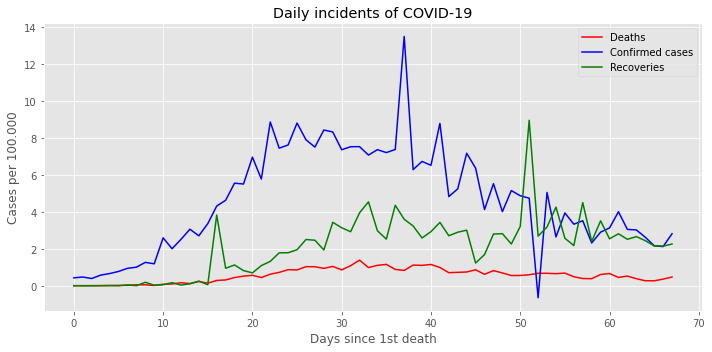

In [0]:
plt.figure(figsize=(10,5))
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams.update({'font.size': 10})
sns.lineplot(df['TimeSince1stDeath'],df['Death'],err_style=None,color="red")
sns.lineplot(df['TimeSince1stDeath'],df['Confirmed'],err_style=None,color="blue")
sns.lineplot(df['TimeSince1stDeath'],df['Recovered'],err_style=None,color="green")
plt.legend(["Deaths","Confirmed cases","Recoveries"])
plt.title('Daily incidents of COVID-19')
plt.ylabel('Cases per 100.000')
plt.xlabel('Days since 1st death')
plt.tight_layout()

From the series we see that the amount of confirmed cases and recoveries are fairly volatile with high variance and sudden spikes, whereas the deaths are more smooth. We know that the amount of confirmed cases and recovered cases depend on the amount of testing done for a particular country, and on which days these tests were conducted. At first glance there are days where there is large influx in amount of confirmed and recovered cases, but this may likely be caused by an increase in test-capacity. It seems, as also deciphered in the news, that there is a large amount of un-reported confirmed and recovered cases, which makes it hard to model these quantities.

However, the amount of deaths seems much more reasonable to model as most of these occur in hospitals and deaths are much more easily identified than a confirmed or a recovered case. 

Despite the low quality of the confirmed cases data, we still believe that the data may prove valuable in predicing the amount of deaths, and we therefore keep it as an exogenous variable in modelling deaths. The recoveries are disregarded as these do not have a causal relationship to the amount of deaths. (Of course if recoveries are very high there may be some sort of saturation in the succeptible population, but some studies show that there is no immunity gained when getting recovered. Nonetheless the amount of recoveries are such a small fraction of the total population anyway that this will not affect the model at its current stage)

The daily deaths for the five countries are seen visualized below.

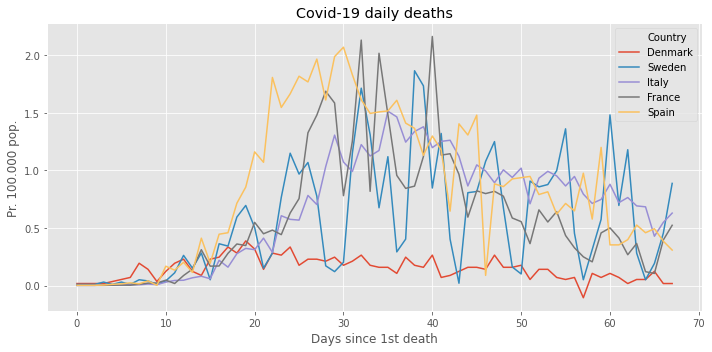

In [0]:
# plot of death and confirmed divided by total population for overview! 
df_sub1 = df
plt.figure(figsize=(10,5))
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams.update({'font.size': 10})
sns.lineplot(df_sub1['TimeSince1stDeath'],df_sub1['Death'],hue=df_sub1['Country'],err_style=None)
plt.title('Covid-19 daily deaths')
plt.ylabel('Pr. 100.000 pop.')
plt.xlabel('Days since 1st death')
plt.tight_layout()


Again we see some systematic in how the deaths occur. It seems that there is some seasonality, especially when looking at the time-series for Sweden. This is likely not due to the fact that there are much fewer deaths every 6th and 7th day, but rather that this information is not reported during these days. For Denmark and Italy the series looks fairly smooth, which would indicate that the death-reports are more consistent on a day-to-day basis. 

The jaggedness of some of the series could be fixed to some extend by smoothing the series, but this would severly lower the number of unique observations available, and for modelling purposes we choose to proceed with the series as they are.

##OECD & Google descriptive data exploration

Descriptive data visualization is conducted for the purpose of gaining more domain knowledge about the variables which will be used in the model. We would also like to assess if there is enough variability between the countries for these variables. The more the countries vary in relation to each other, the better the external inputs might work for modelling purposes (and in identifying what causes different amounts of deaths in one country from another). 


**Exploration of OECD**

In [0]:
variables = (['Acute_myocardial_infarction', 'Asthma', 'Chronic_obstructive_Pulmonary_diseases', 'Diabetes_mellitus', 'Diseases_of_the_respiratory_system', 'Influenza', 'Ischaemic_heart_diseases', 'Pneumonia', 'Population__65_years_old_and_over', 'Population__80_years_old_and_over', 'Air_pollution', 'Rooms_per_person', 'Number of people per household', 'Single person households'])
df = df.drop(columns="Unnamed: 0") # reset_index somewhere 

In [0]:
df_pair = df[variables]
df_pair = df_pair.drop_duplicates(keep='first')

Let's inspect the numbers for each country. It should be noted that the OECD variables are static for all time-steps and therefore the mean does not alter the value for that countries OECD variable.

In [0]:
df.groupby("Country").mean()

Death  Confirmed  ...  ConfirmedNotNormalized  RecoveredNotNormalized
Country                       ...                                                
Denmark  0.145807   2.696517  ...              153.117647              144.323529
France   0.596836   3.882062  ...             2582.058824              851.294118
Italy    0.662497   4.879361  ...             2963.264706             1013.838235
Spain    0.842812   7.042665  ...             3271.308824             2002.411765
Sweden   0.567749   4.516503  ...              448.176471               73.088235

[5 rows x 40 columns]

It should be noted that the Deaths, Confirmed and Recovered cases are measured per 100.000 citizen.
We see that the death-rate in Spain is higher than other countries. Additionally it is seen that Denmark has the lowest death-rate.

From the OECD data we see that Italy have more old people, which may also be influential in a higher death-rate compared to Denmark and Sweden as age is a significant factor in death risk for COVID 19. It is also seen that the air pollution is higher in the southern countries compared to Sweden and Denmark, which may be influencial in the varying numbers of deaths.

**Google dataset**

Below are the time-series for the google data visualized. First the aggergated series across the five countries is presented.

In [0]:
gvars = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']

In [0]:
gvarsT = ['Retail & recreation', # making the titles prettier
 'Grocery & pharmacy',
 'Parks',
 'Transit stations',
 'Workplaces',
 'Residential']

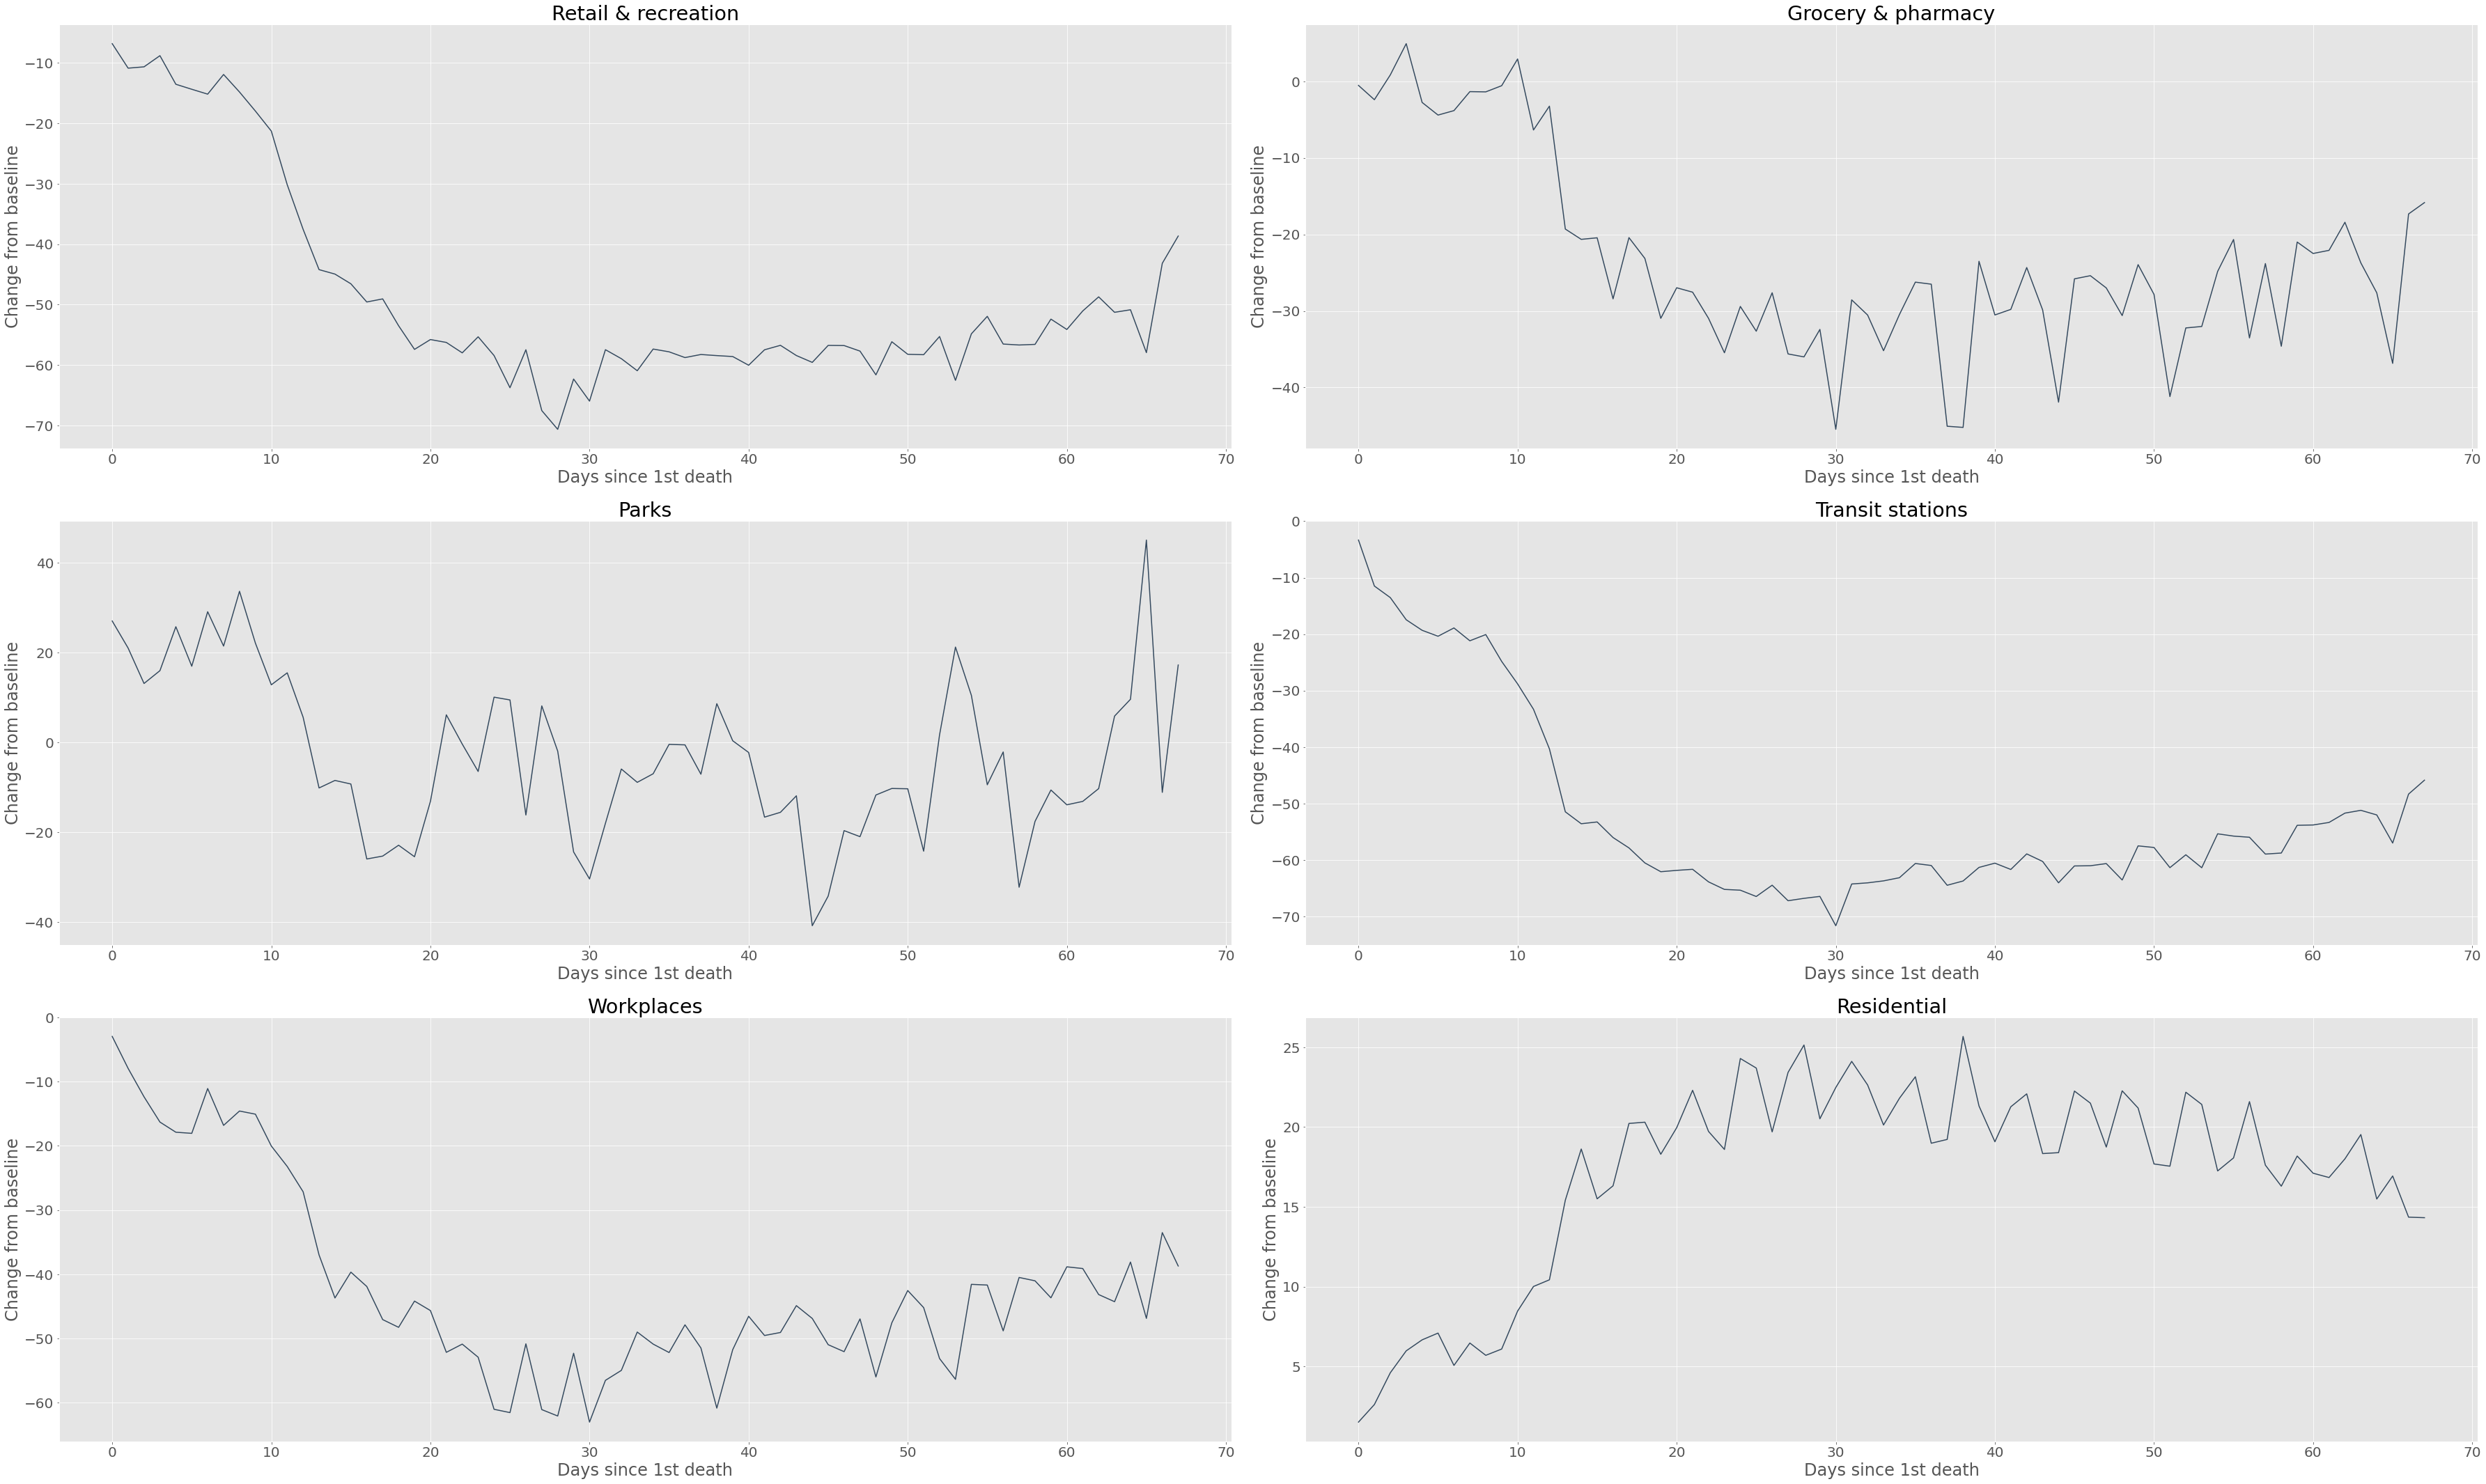

In [0]:
plt.figure(figsize=(50,30))
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams.update({'font.size': 20})
for i in range(len(gvars)):
    ax=plt.subplot(3,2,i+1)
    sns.lineplot(df['TimeSince1stDeath'],df[gvars[i]],err_style=None,color="#34495e")
    plt.title(gvarsT[i])
    ax.set_ylabel('Change from baseline')
    ax.set_xlabel('Days since 1st death')
    #plt.setp(ax.get_xticklabels(), rotation=45)    
plt.tight_layout()
plt.show(ax)

Comments:<br>
- Early peak followed by a drop in grocery/ pharmacy (maybe due to hoarding)
- Decrease in public activities such as transit-stations and retail-recreation.
- Increase in residentials, i.e. people are staying in their homes.


Next, let's look at these for each of the five countries.

In [0]:
df_sub=df

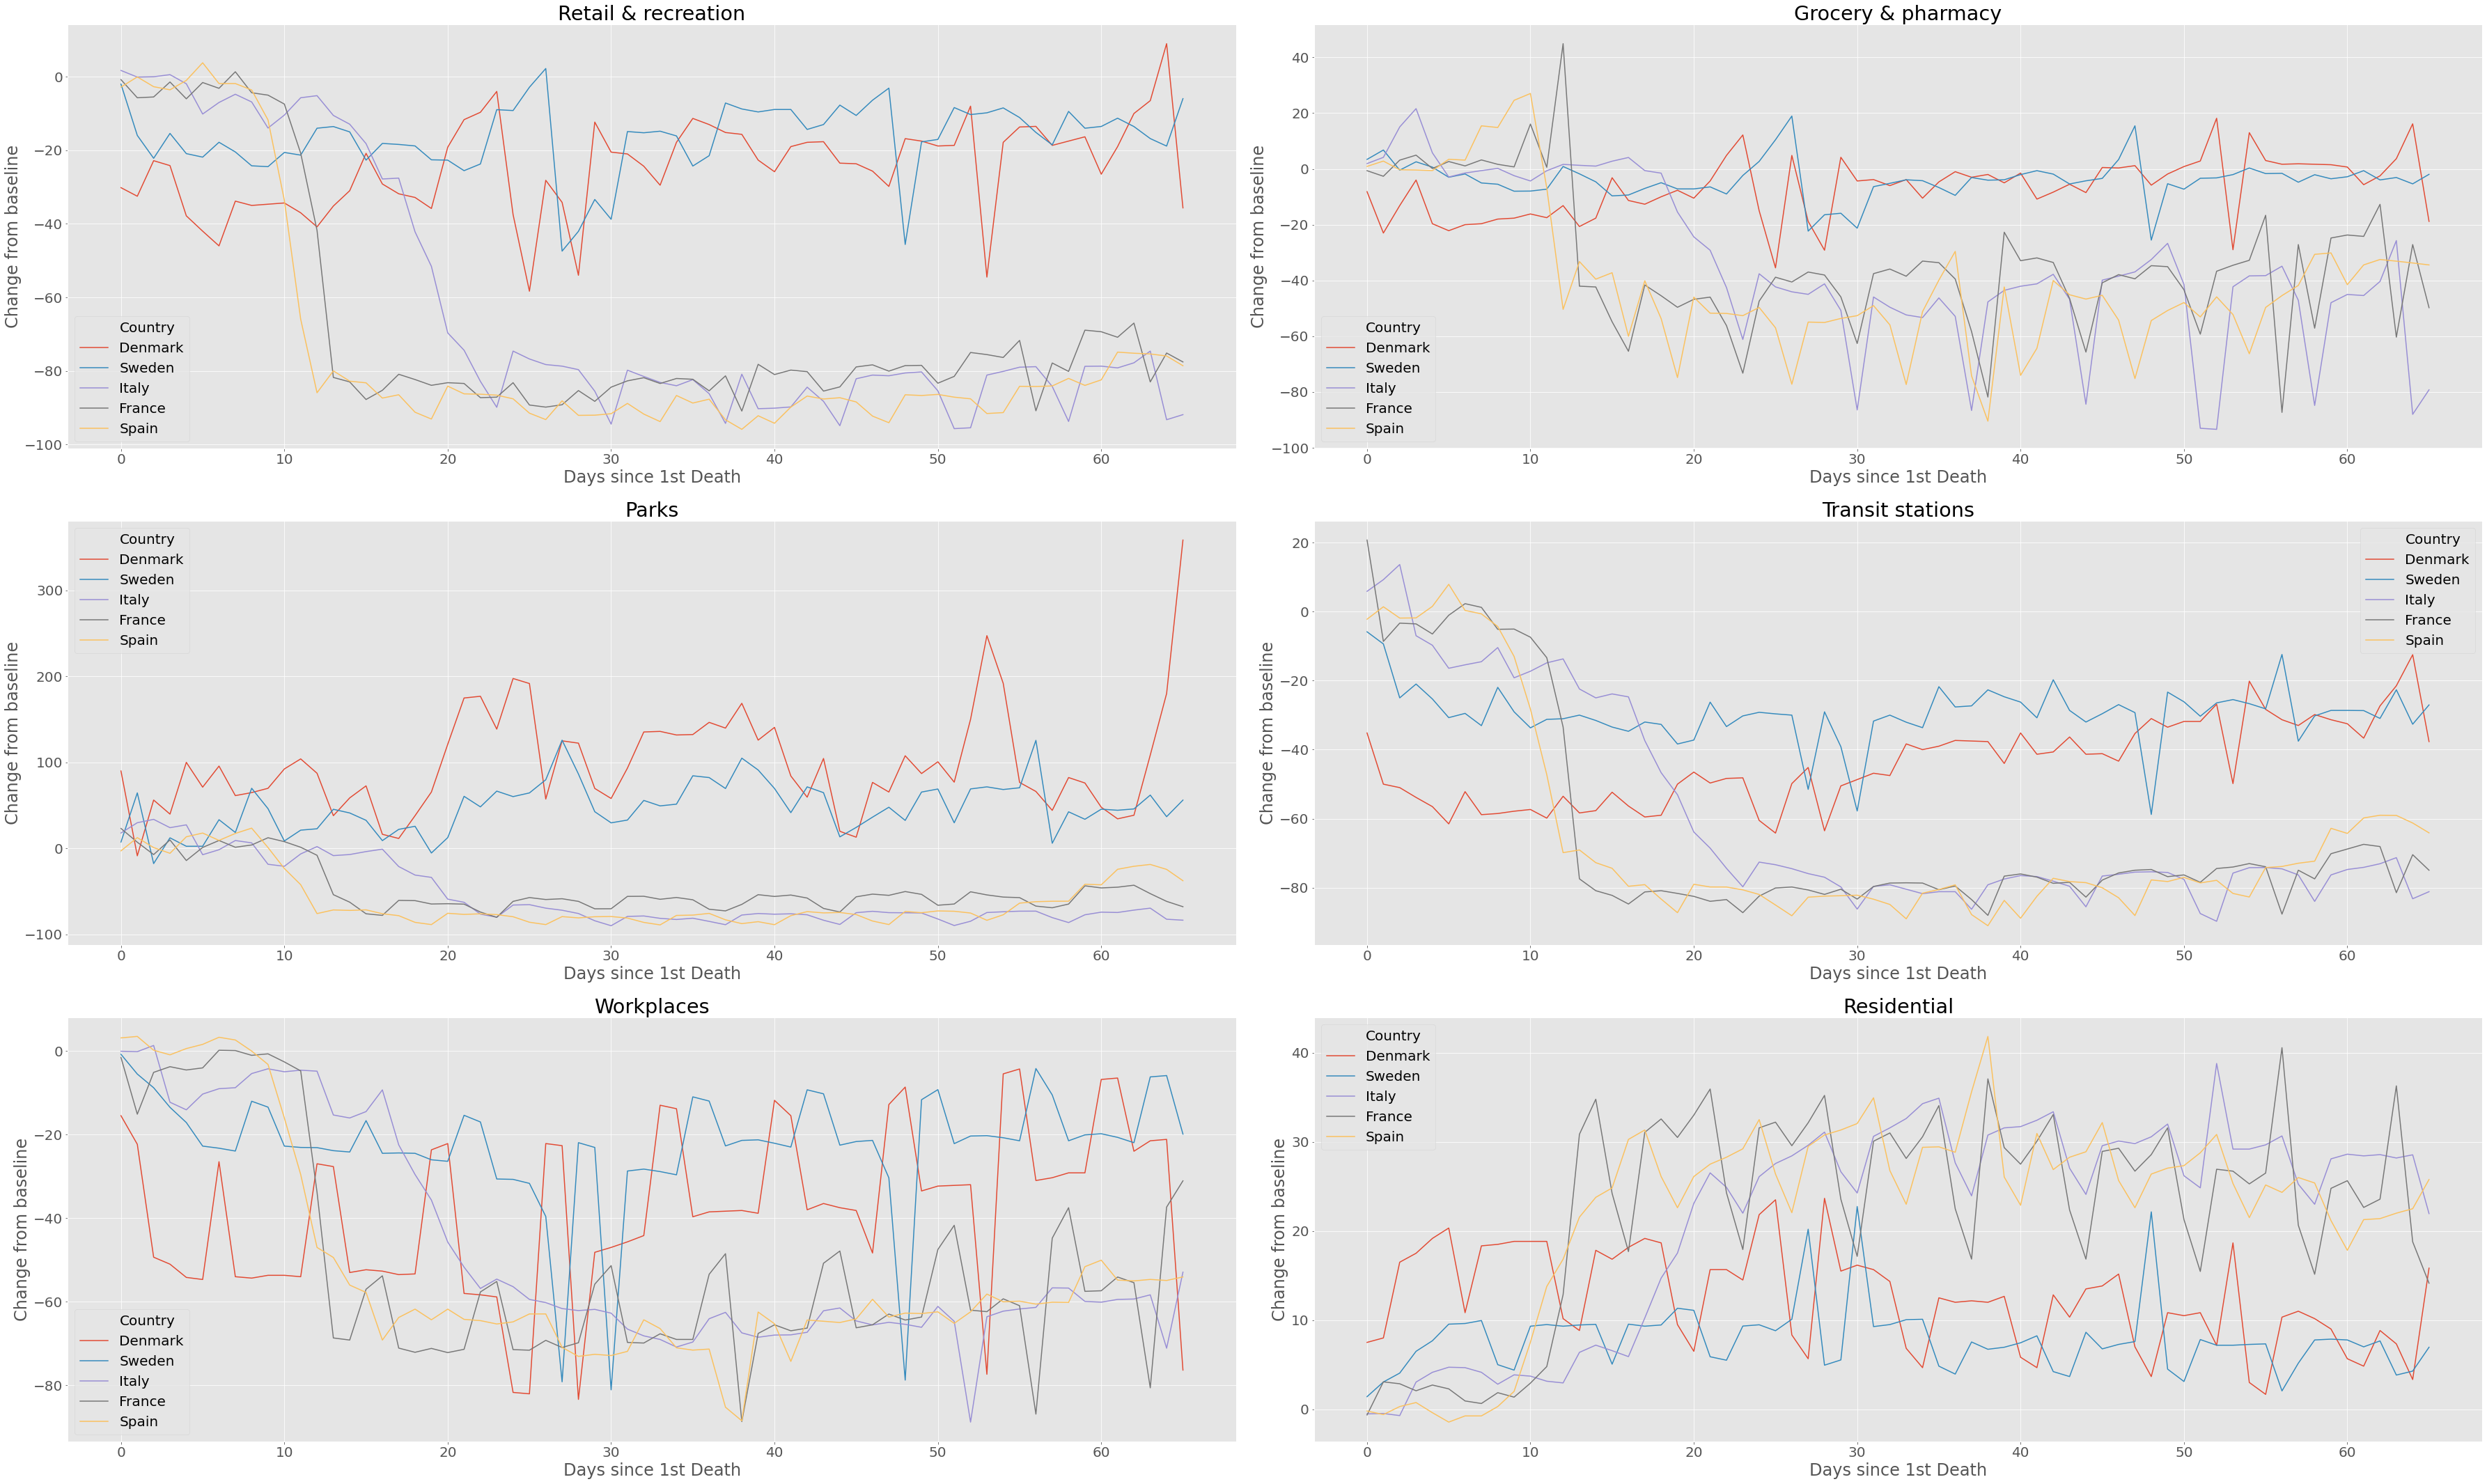

In [0]:
# CHANGE THIS ONE ACCORDINGLY AS WELL
plt.figure(figsize=(50,30))
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams.update({'font.size': 20})
for i in range(len(gvars)):
    ax=plt.subplot(3,2,i+1)
    sns.lineplot(df_sub['TimeSince1stDeath'],df_sub[gvars[i]],hue=df_sub['Country'],err_style=None,color="#34495e")
    plt.title(gvarsT[i])
    ax.set_ylabel('Change from baseline')
    ax.set_xlabel('Days since 1st Death')
    #plt.setp(ax.get_xticklabels(), rotation=45) 
plt.tight_layout()
plt.show()

Comments:<br>

It appears that Danes and Swedes are much more prone to have activities outside of their homes compared to Spanish, French and Italian people. Perhaps their baseline is vastly different, for example as the park-activity might be much higher in January and February in the south, or that the countries political strategy is in much more of a lock-down state compared to Scandinavian countries.

The latter seems to be the case, as the google-data shows larger deviations from baseline for public activities (workplace-presence, transit station-presence and retail-presence) whereas there is an increase in the amount of people in their residentials - thus indicating these southern countries are more prone to staying home than Swedes and Danes.


The 'fluctuations' in workplace is that we are closer to the baseline in the weekends because we are normally at home there.
Ditto for residential: 'fall' in weekends is because we are normally at home there (so closer to baseline). 
Overall: there also seems to be quite some variability here - so well suited for modelling.


It seems that there is a decent amount of variability in both the COVID-19 data and the Google Mobility data and OECD numbers. Since the phenomenon of COVID-19 is very intricate, it will naturally not be easy to model, but hopefully the external variables will prove useful in, atleast somewhat, determining what causes differences in death-tolls for the different countries. Onwards to modelling!

# Modelling the spread of COVID-19

We will model the spread of COVID-19 as a *multivariate state space model*, more specifically as *linear dynamical system*. We will start with a simple model, and iteratively add features along the way and assess how the new implementation impacts model performance. We take the following steps:

* Multivariate LDS model
* \+ changed emission probabilities
* \+ OECD covariates implemented in emission
* \+ Google covariates implemented between latent states
<br>

With these models we will hopefully achieve the goals stated in the notebook introduction, which are to:<br>
1) Create a PGM that can predict the spread of COVID-19 for a number of individual countries with an acceptable accuracy.<br>
2) Learn more about the variables that are typically used as explanatory variables in explaining the difference in the severity of the spread of the virus between different countries/regions. More specifically, estimate the relative importance of each variable vis-à-vis one another.  


# LDS model

**Theory**<br>
The figure belows shows the representation of the model. $\text{Z}$ denotes the latent states. At each timestep we sample 5 $\text{y}$s, that is one from each of the 5 countries. So $\text{y}_{1,1}$ denotes the sampled deaths for the first country at timestep 1.  

![](https://drive.google.com/uc?id=1q0yGHjJ6LWY-FT9HCbdFxHvqV2VeVAYT)

This model has the following formulation:

Latent dynamics:
\begin{align}
z_t &\sim \mathcal{N}(z_t|\beta z_{t-1}, \Sigma)\\
\end{align}

And emission probabilities:
\begin{align}
y_t &\sim \mathcal{N}(y_t |z_t, \sigma^2)
\end{align}

So the number of daily new deaths are dependent on the number of daily new deaths registered the previous day multiplied by a coefficient. The predicted new daily deaths at timestep t are governed by the emission probabilities that are normally distributed around $z_t$ with some variance $\sigma^2$.<br>
*Note to reader*: Initially we wished to model the emission probability using a truncated normal distribution since negative values for the predictions are not possible. We faced many implementation issues using this approach, and therefore decide to settle on the normal distribution - which was possible to implement using NumPyro. 

When modelling the covid deaths the covariance matrix,  $\boldsymbol\Sigma$, will capture correlation  between the countries.

Following the standard approach, the **LKJ prior** is used when modeling the covariance matrix of a multivariate normal distribution. 

\begin{align}
\boldsymbol\Sigma_{lowertriangular} = \mbox{diag_matrix}(\boldsymbol\tau) \, \boldsymbol\Omega
\end{align}


where $\mbox{diag_matrix}(\boldsymbol\tau)$ denotes a diagonal matrix with diagonal elements given by the vector $\boldsymbol\tau$. In this parameterization, $\boldsymbol\Omega$ can be regarded as a correlation matrix and $\boldsymbol\tau$ is a vector of coefficient scales.


\begin{align}
\boldsymbol\tau ∼ Cauchy(0, 1.0)
\end{align}

###Model implementation <br>


The code used to create the multivariate LDS, and the theory presented above is inspired by the provided notebook for **lecture 7 - temporal models part 4**. <br>
<br>

*Note regarding plates:* As an alternative aproach which was initaily chased we used plates in the model repeating the procedure for each country. This way only time series correlation within countries was modeled. Due to instability of NumPyro it was decided to use an alternative aproach as seen in this notebook. Here all countries share the same covariance matrix so that correlation is modeled between all time series. **We spent quite an amount of time in defining these models before abandoning the approach. This work can (and should :-) ) be seen in the attached Notebook "Appendix Notebook".**   

In [0]:
# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

Lets start by loading the dataset

In [0]:
data=pd.read_csv('/content/drive/My Drive/Modelbased ML Project/covid_and_externalvars_t0death.csv')

Merging data to contain 5 time series. One for each of the countries:

In [0]:
#Loading Denmark, Italy, Spain, Sweden and France in its own dataframe
denmark = data[data["Country"] == "Denmark"]
denmark = denmark.reset_index()
italy=data[data["Country"] == "Italy"]
italy = italy.reset_index()
spain=data[data["Country"] == "Spain"]
spain = spain.reset_index()
sweden=data[data["Country"] == "Sweden"]
sweden = sweden.reset_index()
france=data[data["Country"] == "France"]
france = france.reset_index()

#Concatenating the countries
two_countries=denmark.merge(italy,left_index=True,right_index=True,suffixes=('_denmark','_italy'))
three_countries=two_countries.merge(spain,left_index=True,right_index=True,suffixes=('','_spain')) #NB: Somehow spain suffixes does not work
four_countries=three_countries.merge(sweden,left_index=True,right_index=True,suffixes=('','_sweden')) 
five_countries=four_countries.merge(france,left_index=True,right_index=True,suffixes=('','_france'))

Selecting death time series from the data:


In [0]:
five_countries=five_countries[['Death_denmark','Death_italy','Death','Death_sweden','Death_france']]

In [0]:
df=five_countries

Split data into train/test

In [0]:
y = df.values
N, D = y.shape
print("N=%d, D=%d" % (N,D))

N=68, D=5


In [0]:
ix_train = range(0, 58) #This is chosen by us - when datasæt is "t0-data" then this doesnt matter
ix_test = range(58, 68)
N_train = len(ix_train)
N_test = len(ix_test)
print("N_train:", N_train)
print("N_test:", N_test)


#Select train and test data
y_train = y[ix_train,:]
y_test = y[ix_test,:]

#Number of features (D)
nf_data = D #This represent the number of features in the dataset (5 time series)

N_train: 58
N_test: 10


Defining the carryfunction for the LDS.

In [0]:
def f(carry, noise_t):
  beta, z_prev, tau = carry
  z_t = beta*z_prev + noise_t * tau
  z_prev = z_t
  return (beta, z_prev, tau), z_t

Defining the model.

In [0]:
from torch.distributions import constraints
import numpy

def model(T, T_forecast,nf = nf_data,n_forcast = 0, obs_matrix=None):
    
    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=jnp.ones(nf), scale=jnp.ones(nf)))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(nf)))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=2))

    z_prev = numpyro.sample(name="z_1", fn=dist.Normal(loc=jnp.ones(nf), scale=jnp.ones(nf)))
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(nf, 10.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(tau)), L_Omega) # lower cholesky factor of the covariance matrix
    noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(nf), scale_tril=Sigma_lower), sample_shape=(T+T_forecast-1,))
    

    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(f, carry, noises, T+T_forecast-1)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    numpyro.sample(name="y_obs_death_denmark", fn=dist.Normal(loc=z_collection[:T,0], scale=sigma), obs=obs_matrix[:,0])
    numpyro.sample(name="y_obs_death_italy", fn=dist.Normal(loc=z_collection[:T,1], scale=sigma), obs=obs_matrix[:,1])
    numpyro.sample(name="y_obs_death_spain", fn=dist.Normal(loc=z_collection[:T,2], scale=sigma), obs=obs_matrix[:,2])
    numpyro.sample(name="y_obs_death_sweden", fn=dist.Normal(loc=z_collection[:T,3], scale=sigma), obs=obs_matrix[:,3])
    numpyro.sample(name="y_obs_death_france", fn=dist.Normal(loc=z_collection[:T,4], scale=sigma), obs=obs_matrix[:,4])

    if (n_forcast > 0): 
      numpyro.sample(name="y_pred_death_denmark", fn=dist.Normal(loc=z_collection[T:,0], scale=sigma), obs=None)
      numpyro.sample(name="y_pred_death_italy", fn=dist.Normal(loc=z_collection[T:,1], scale=sigma), obs=None)
      numpyro.sample(name="y_pred_death_spain", fn=dist.Normal(loc=z_collection[T:,2], scale=sigma), obs=None)
      numpyro.sample(name="y_pred_death_sweden", fn=dist.Normal(loc=z_collection[T:,3], scale=sigma), obs=None)
      numpyro.sample(name="y_pred_death_france", fn=dist.Normal(loc=z_collection[T:,4], scale=sigma), obs=None)


MCMC Inference


In [0]:
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model, step_size=5e-2, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=N_train, T_forecast=N_test, obs_matrix=y_train) 
t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 4000/4000 [03:34<00:00, 18.61it/s, 1023 steps of size 4.35e-03. acc. prob=0.95]


Total time: 3.848m


In [0]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
L_Omega[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
L_Omega[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
L_Omega[0,2]      0.00      0.00      0.00      0.00      0.00       nan       nan
L_Omega[0,3]      0.00      0.00      0.00      0.00      0.00       nan       nan
L_Omega[0,4]      0.00      0.00      0.00      0.00      0.00       nan       nan
L_Omega[1,0]      0.05      0.17      0.05     -0.23      0.32   1017.55      1.00
L_Omega[1,1]      0.98      0.02      0.99      0.96      1.00   1646.86      1.00
L_Omega[1,2]      0.00      0.00      0.00      0.00      0.00       nan       nan
L_Omega[1,3]      0.00      0.00      0.00      0.00      0.00       nan       nan
L_Omega[1,4]      0.00      0.00      0.00      0.00      0.00       nan       nan
L_Omega[2,0]      0.07      0.18      0.07     -0.22      0.37   1133.96      1.00
L_O

In [0]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

In order to verify that the MCMC algorithm is properly tuned, the trace-plots for a select few of the variables are visualized.

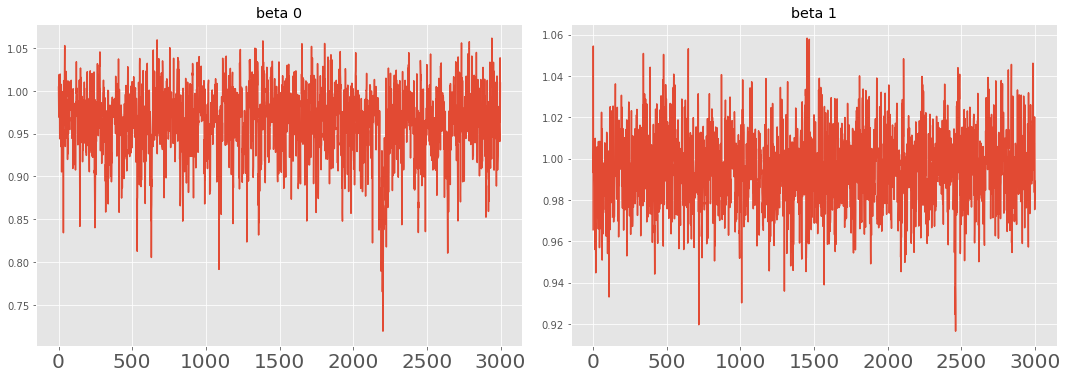

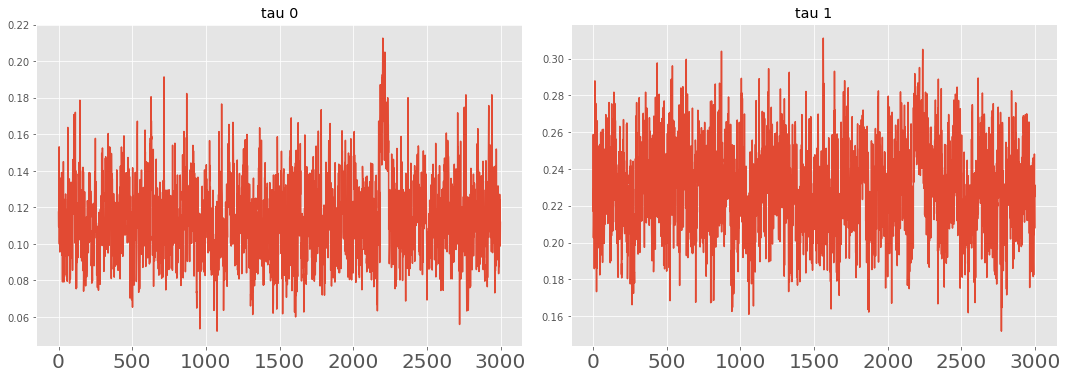

In [0]:
plt.figure(figsize=(15,10))
for i in range(2):
    ax=plt.subplot(2,2,i+1)
    plt.plot(pd.DataFrame(hmc_samples['beta'][:,i]))
    
    plt.title("beta "+str(i))
    #plt.setp(ax.get_xticklabels(), rotation=45)    
plt.tight_layout()
plt.show(ax)

plt.figure(figsize=(15,10))
for i in range(2):
    ax=plt.subplot(2,2,i+1)
    plt.plot(pd.DataFrame(hmc_samples['tau'][:,i]))
    
    plt.title("tau "+str(i))
    #plt.setp(ax.get_xticklabels(), rotation=45)    
plt.tight_layout()
plt.show(ax)

From the trace-plots it appears that the model may have converged to a reasonable solution, and that the step-size appears reasonable. Given the nature of the jumps it seems that the posterior distribution for the variable is close to that of a normal distribution, which is also seen when inspecting the distribution plots below.

Creating distribution plots in order to inspect the model variables.

In [0]:
# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

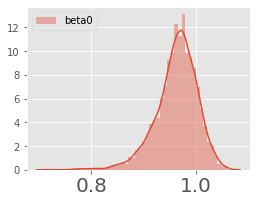

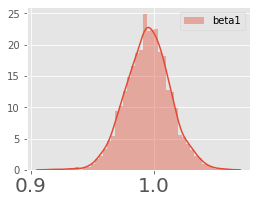

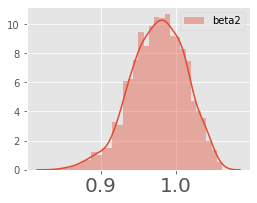

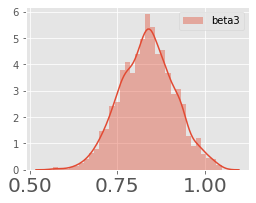

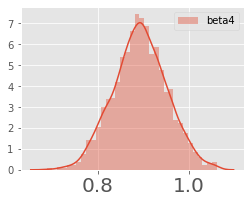

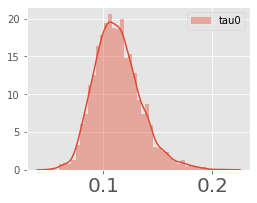

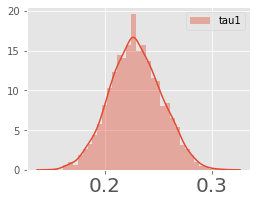

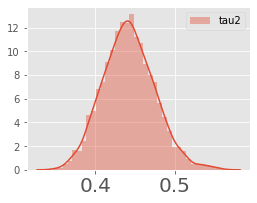

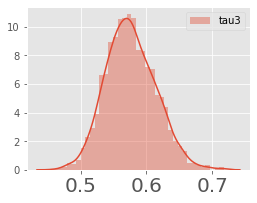

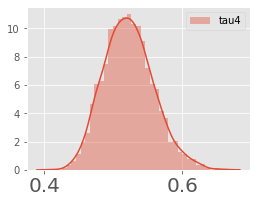

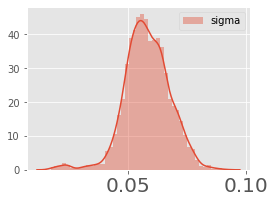

In [0]:
nodes = ["beta", "tau", "sigma"]
for node in nodes:
  if node == "beta" or node=='tau':
    for i in range(nf_data):
      plt.figure(figsize=(4,3))
      sns.distplot(hmc_samples[node][:,i], label=node+"%d"%i)
      plt.legend()
    plt.show()
  else:
    plt.figure(figsize=(4,3))
    sns.distplot(hmc_samples[node], label=node)
    plt.legend()
    plt.show()

Inspecting the distributions we see that there is variance in the posterior samples, and the values are distributions are generally positive.

Using numpyro's predictive classs to predict COVID death for the 5 countries.

In [0]:
from numpyro.infer import Predictive
rng_key = random.PRNGKey(0)
predictive = Predictive(model,posterior_samples=mcmc.get_samples())
y_pred_1 = predictive(rng_key,T=N_train, T_forecast=N_test,n_forcast = 10,obs_matrix=y_train)["y_pred_death_denmark"]
y_pred_2 = predictive(rng_key,T=N_train, T_forecast=N_test,n_forcast = 10,obs_matrix=y_train)["y_pred_death_italy"]
y_pred_3 = predictive(rng_key,T=N_train, T_forecast=N_test,n_forcast = 10,obs_matrix=y_train)["y_pred_death_spain"]
y_pred_4 = predictive(rng_key,T=N_train, T_forecast=N_test,n_forcast = 10,obs_matrix=y_train)["y_pred_death_sweden"]
y_pred_5 = predictive(rng_key,T=N_train, T_forecast=N_test,n_forcast = 10,obs_matrix=y_train)["y_pred_death_france"]

Calculating model average MSE <br>
*Note to reader:* We acknowledge that MSE might not be the most suitable performance metric for this type of modelling problem, in the sense that some of the MSEs wont be comparable, say between timeseries of two countries because the deaths have different magnitudes. But MSEs between models, that is this one and the next model extension will be comparable, and that is the primary function of calculating the MSE: to see if our models perform better in relation to each other when extending them.

In [0]:
from sklearn.metrics import mean_squared_error

#calculating mean of predictions for each timeseries
mean_preds_1_M1=y_pred_1.mean(axis=0).reshape(-1,) 
mean_preds_2_M1=y_pred_2.mean(axis=0).reshape(-1,)
mean_preds_3_M1=y_pred_3.mean(axis=0).reshape(-1,)
mean_preds_4_M1=y_pred_4.mean(axis=0).reshape(-1,)
mean_preds_5_M1=y_pred_5.mean(axis=0).reshape(-1,)

# calulating MSE for each timeseries on the test set
MSE1_M1=mean_squared_error(y_test.T[[0][0]], mean_preds_1_M1)
MSE2_M1=mean_squared_error(y_test.T[[1][0]], mean_preds_2_M1)
MSE3_M1=mean_squared_error(y_test.T[[2][0]], mean_preds_3_M1)
MSE4_M1=mean_squared_error(y_test.T[[3][0]], mean_preds_4_M1)
MSE5_M1=mean_squared_error(y_test.T[[4][0]], mean_preds_5_M1) 

# calculating the average of time series MSE, finding estimate of model MSE
model_avg_MSE_M1 = np.mean([MSE1_M1,MSE2_M1,MSE3_M1,MSE4_M1,MSE5_M1])
model_avg_MSE_M1

0.15941193443909712

The MSE for the four models will be compared and presented later. 


Finally, we plot the prediction of the model to visually asses the performance as well. 

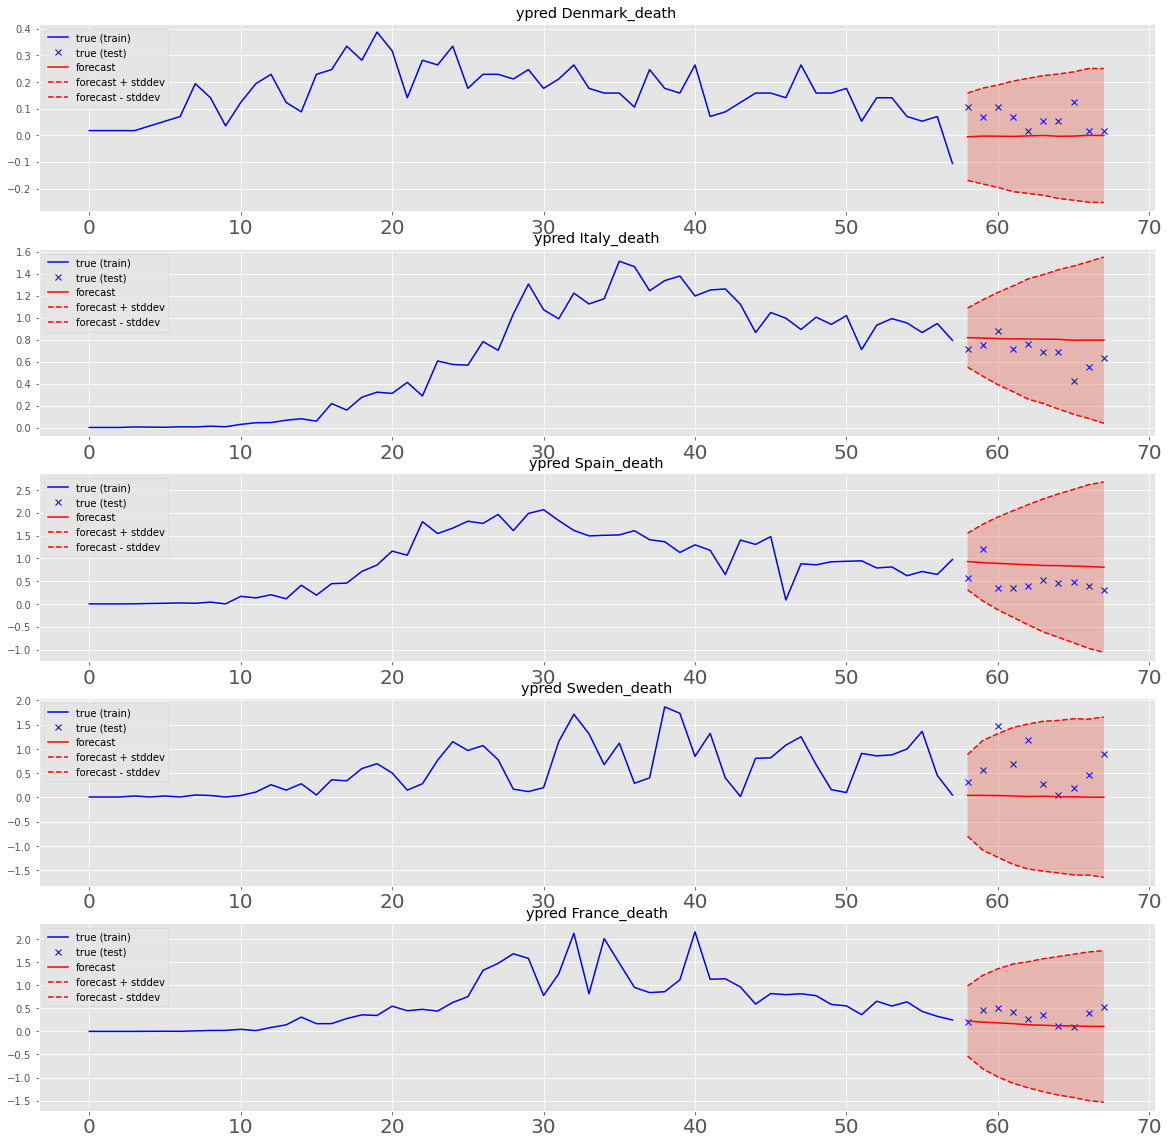

In [0]:
fig, axs = plt.subplots(nf_data,1, figsize=(20, 20))

axs = axs.ravel()
for i in range(nf_data):
  
  Chooseplot = i+1
  if (Chooseplot==1):
    q=y_pred_1
  elif (Chooseplot==2):
    q=y_pred_2
  elif (Chooseplot==3):
    q=y_pred_3
  elif (Chooseplot==4):
    q=y_pred_4
  elif (Chooseplot==5):
    q=y_pred_5
  

  q_mean = q.mean(axis=0).reshape(-1,)
  q_std = q.std(axis=0).reshape(-1,)
  y_pred_025 = q_mean - 1.96*q_std
  y_pred_975 = q_mean + 1.96*q_std
  y_pred_mean = q_mean

  axs[i].plot(ix_train, y_train[:, Chooseplot-1], "b-")
  axs[i].plot(ix_test, y_test[:, Chooseplot-1], "bx")
  axs[i].plot(ix_test, y_pred_mean[-N_test:], "r-")
  axs[i].plot(ix_test, y_pred_025[-N_test:], "r--")
  axs[i].plot(ix_test, y_pred_975[-N_test:], "r--")
  axs[i].fill_between(ix_test, y_pred_025, y_pred_975, alpha=0.3)
  axs[i].legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])

  if(Chooseplot==1):
    plotname='Denmark_death'
  elif(Chooseplot==2):
    plotname='Italy_death'
  elif(Chooseplot==3):
    plotname='Spain_death'
  elif(Chooseplot==4):
    plotname='Sweden_death'
  elif(Chooseplot==5):
    plotname='France_death'

  axs[i].set_title("ypred "+ plotname)

As previously mentioned, values below 0 are not meaningful, but this constrain was omitted due to NumPyro issues with TruncatedNormal distribution. We see that predictions are somewhat close to the true data points, but also that the prediction interval is very large, indicating large amount of uncertainty.

# LDS model with C and $\Sigma $ in emission probability

In this model expansion we assess the impact of changing the emission probabilities. In the previous model, predictions were simply sampled from a normal distribution around the latent state with some fixed variance. Now, we add a learned coefficient (**C**) that is to be multiplied onto the latent state when sampling $y$. We also allow for covariance between the countries ($\Sigma_2$) to have an impact of the emission probabilities. The PGM is shown in the figure below:

![alt text](https://drive.google.com/uc?id=1cwTTqmrITXBignfKAdidJoGaxPzf1WIJ)

Unchanged latent dynamics:
\begin{align}
z_t &\sim \mathcal{N}(z_t|\beta z_{t-1}, \Sigma_1)\\
\end{align}

And new emission probabilities:
\begin{align}
y_t &\sim \mathcal{N}(y_t|Cz_t, \Sigma_2)
\end{align}

The predicted new daily deaths at timestep t are now governed by the emission probabilities that is a normal distribution centered at $Cz_t$ with some variance $\Sigma_2$ allowing more modelling dependencies between countries also here.

Introducing a full coriance matrix, $\Sigma_2$, will also mean a introduction of a matrix with NxN parameters. This will increase the computation time, but hopefully result in even better COVID predictions. 

## Model implementation



We redefine the carry function for the normal LDS. The new implementation is the $y_t$ which depends on the coefficient $C$.

In [0]:
def f(carry, noise_list):
  beta, z_prev, tau, C, tau_2 = carry
  z_t = beta*z_prev + noise_list[0] * tau
  y_t= C*z_t + noise_list[1] * tau_2
  z_prev = z_t
  return (beta, z_prev, tau,C,tau_2), y_t

Define the model. The new implementation is the $C$ and $\Sigma$ for the $y$ samples. The z_collection is replaced by a y_collection.

In [0]:
from torch.distributions import constraints
import numpy

def model(T, T_forecast,nf = nf_data,n_forcast = 0, obs_matrix=None):
    
    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=jnp.ones(nf), scale=jnp.ones(nf)))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(nf)))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=2))

    z_prev = numpyro.sample(name="z_1", fn=dist.Normal(loc=jnp.ones(nf), scale=jnp.ones(nf)))
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(nf, 10.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(tau)), L_Omega) # lower cholesky factor of the covariance matrix
    noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(nf), scale_tril=Sigma_lower), sample_shape=(T+T_forecast-1,))
    
    #####Multivariate COVARIANCE######

    C = numpyro.sample(name="C", fn=dist.Normal(loc=jnp.ones(nf), scale=jnp.ones(nf)))

    tau_2 = numpyro.sample(name="tau_2", fn=dist.HalfCauchy(scale=jnp.ones(nf)))
    L_Omega_2 = numpyro.sample("L_Omega_2", dist.LKJCholesky(nf, 10.))
    Sigma_lower_2 = jnp.matmul(jnp.diag(jnp.sqrt(tau_2)), L_Omega_2)
    noises_2 = numpyro.sample("noises_2", fn=dist.MultivariateNormal(loc=jnp.zeros(nf), scale_tril=Sigma_lower_2), sample_shape=(T+T_forecast-1,))

    ##################################

    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, z_prev, tau, C, tau_2)
    y_collection=[z_prev]
    carry, ys_exp = lax.scan(f, carry, [noises,noises_2], T+T_forecast-1) 
    y_collection = jnp.concatenate((jnp.array(y_collection), ys_exp), axis=0)


    
    numpyro.sample(name="y_obs_death_denmark", fn=dist.Normal(loc=y_collection[:T,0], scale=sigma), obs=obs_matrix[:,0])
    numpyro.sample(name="y_obs_death_italy", fn=dist.Normal(loc=y_collection[:T,1], scale=sigma), obs=obs_matrix[:,1])
    numpyro.sample(name="y_obs_death_spain", fn=dist.Normal(loc=y_collection[:T,2], scale=sigma), obs=obs_matrix[:,2])
    numpyro.sample(name="y_obs_death_sweden", fn=dist.Normal(loc=y_collection[:T,3], scale=sigma), obs=obs_matrix[:,3])
    numpyro.sample(name="y_obs_death_france", fn=dist.Normal(loc=y_collection[:T,4], scale=sigma), obs=obs_matrix[:,4])
    


    if (n_forcast > 0): 
      numpyro.sample(name="y_pred_death_denmark", fn=dist.Normal(loc=y_collection[T:,0], scale=sigma), obs=None)
      numpyro.sample(name="y_pred_death_italy", fn=dist.Normal(loc=y_collection[T:,1], scale=sigma), obs=None)
      numpyro.sample(name="y_pred_death_spain", fn=dist.Normal(loc=y_collection[T:,2], scale=sigma), obs=None)
      numpyro.sample(name="y_pred_death_sweden", fn=dist.Normal(loc=y_collection[T:,3], scale=sigma), obs=None)
      numpyro.sample(name="y_pred_death_france", fn=dist.Normal(loc=y_collection[T:,4], scale=sigma), obs=None)

MCMC Inference


In [0]:
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model, step_size=5e-2, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=N_train, T_forecast=N_test, obs_matrix=y_train) 
t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 4000/4000 [06:36<00:00, 10.09it/s, 1023 steps of size 2.25e-03. acc. prob=0.82]


Total time: 6.870m


In [0]:
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
          C[0]     -0.35      0.39     -0.20     -0.84     -0.01     37.18      1.02
          C[1]      0.93      0.64      0.81      0.07      1.84    114.45      1.06
          C[2]     -0.53      0.38     -0.44     -1.04     -0.08    109.90      1.01
          C[3]      1.31      0.71      1.18      0.32      2.40    117.14      1.01
          C[4]     -0.50      0.40     -0.38     -1.09     -0.04     86.73      1.00
  L_Omega[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
  L_Omega[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
  L_Omega[0,2]      0.00      0.00      0.00      0.00      0.00       nan       nan
  L_Omega[0,3]      0.00      0.00      0.00      0.00      0.00       nan       nan
  L_Omega[0,4]      0.00      0.00      0.00      0.00      0.00       nan       nan
  L_Omega[1,0]     -0.04      0.16     -0.04     -0.32      0.21

Again, visualizing the traceplots for some of the variables:

In [0]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

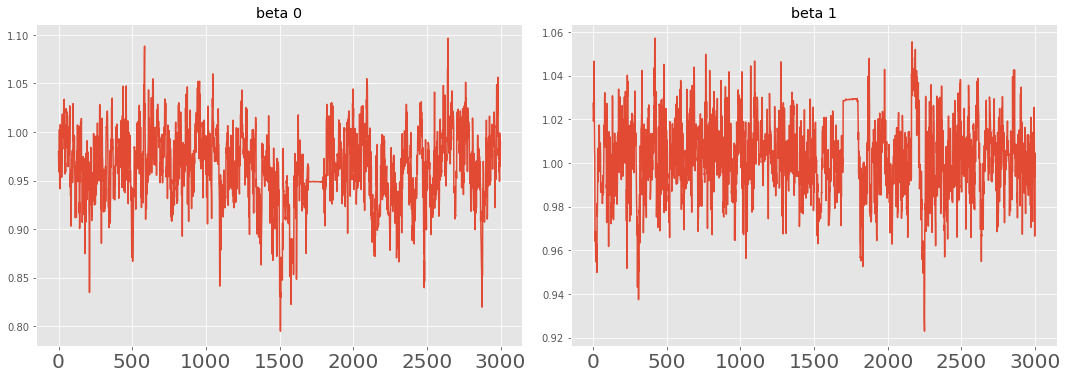

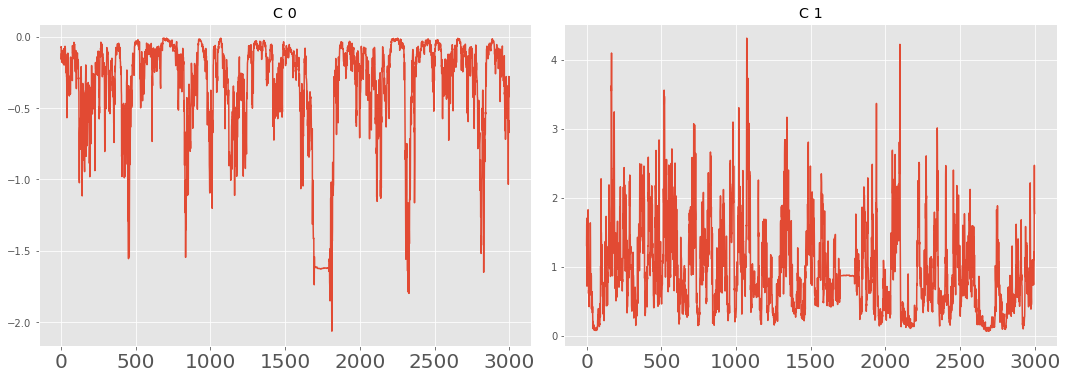

In [0]:
import seaborn as sns

plt.figure(figsize=(15,10))
for i in range(2):
    ax=plt.subplot(2,2,i+1)
    plt.plot(pd.DataFrame(hmc_samples['beta'][:,i]))
    
    plt.title("beta "+str(i))
    #plt.setp(ax.get_xticklabels(), rotation=45)    
plt.tight_layout()
plt.show(ax)

plt.figure(figsize=(15,10))
for i in range(2):
    ax=plt.subplot(2,2,i+1)
    plt.plot(pd.DataFrame(hmc_samples['C'][:,i]))
    
    plt.title("C "+str(i))
    #plt.setp(ax.get_xticklabels(), rotation=45)    
plt.tight_layout()
plt.show(ax)

From the trace-plots it appears that the betas are converged to some extent. The C coefficient traces shows that there some tendency of multimodallity. 

The trace plots look more unstable (less similar to a spiked hedgehog) and not as compact as earlier. We can however see cyceling through some of the same values for the varibles. This raises questions regarding the reliability of the MCMC results. This was, however, the configurations (tested for) with the most stable output.

Inspecting the distribution of the model variables.

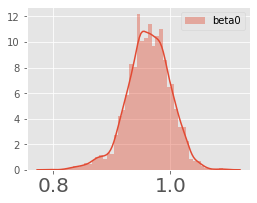

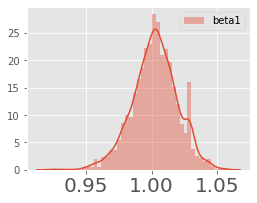

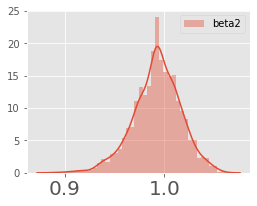

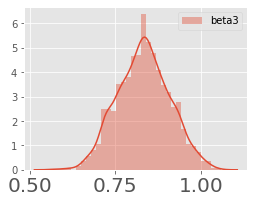

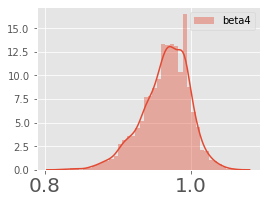

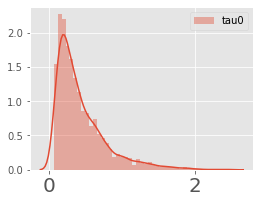

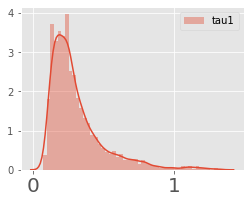

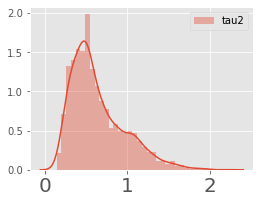

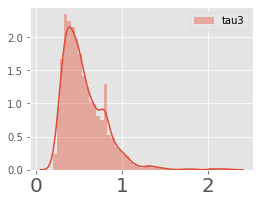

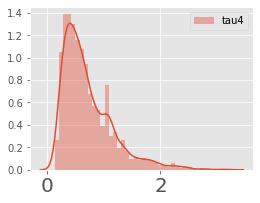

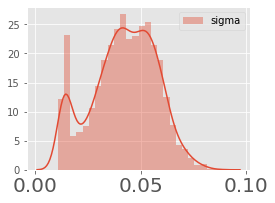

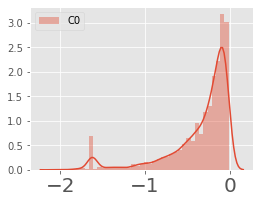

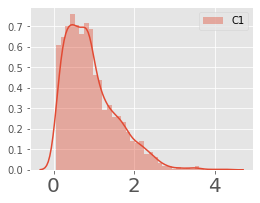

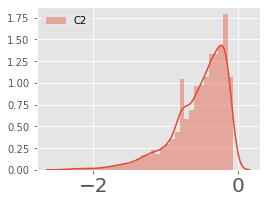

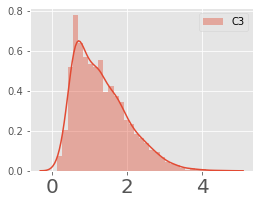

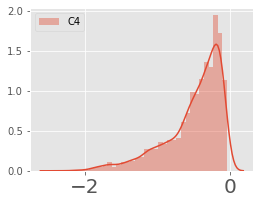

In [0]:
nodes = ["beta", "tau", "sigma","C"]
for node in nodes:
  if node == "beta" or node=='tau' or node=='tau_2' or node=="C" :
    for i in range(nf_data):
      plt.figure(figsize=(4,3))
      sns.distplot(hmc_samples[node][:,i], label=node+"%d"%i)
      plt.legend()
    plt.show()
  else:
    plt.figure(figsize=(4,3))
    sns.distplot(hmc_samples[node], label=node)
    plt.legend()
    plt.show()

From the trace plot we saw tendency of multimodallity, and this also appears in the distribution plot specifiacally for C0. In addition we see that some of the posteriors are more skewed than before.

Using the NumPyro predictive class to predict COVID death for each of the 5 countries.

In [0]:
from numpyro.infer import Predictive
rng_key = random.PRNGKey(0)
predictive = Predictive(model,posterior_samples=mcmc.get_samples())
y_pred_1 = predictive(rng_key,T=N_train, T_forecast=N_test,n_forcast = 10,obs_matrix=y_train)["y_pred_death_denmark"]
y_pred_2 = predictive(rng_key,T=N_train, T_forecast=N_test,n_forcast = 10,obs_matrix=y_train)["y_pred_death_italy"]
y_pred_3 = predictive(rng_key,T=N_train, T_forecast=N_test,n_forcast = 10,obs_matrix=y_train)["y_pred_death_spain"]
y_pred_4 = predictive(rng_key,T=N_train, T_forecast=N_test,n_forcast = 10,obs_matrix=y_train)["y_pred_death_sweden"]
y_pred_5 = predictive(rng_key,T=N_train, T_forecast=N_test,n_forcast = 10,obs_matrix=y_train)["y_pred_death_france"]

Calculating model average MSE

In [0]:
from sklearn.metrics import mean_squared_error

#calculating mean of predictions for each timeseries
mean_preds_1_M2=y_pred_1.mean(axis=0).reshape(-1,) 
mean_preds_2_M2=y_pred_2.mean(axis=0).reshape(-1,)
mean_preds_3_M2=y_pred_3.mean(axis=0).reshape(-1,)
mean_preds_4_M2=y_pred_4.mean(axis=0).reshape(-1,)
mean_preds_5_M2=y_pred_5.mean(axis=0).reshape(-1,)

# calulating MSE for each timeseries on the test set
MSE1_M2=mean_squared_error(y_test.T[[0][0]], mean_preds_1_M2)
MSE2_M2=mean_squared_error(y_test.T[[1][0]], mean_preds_2_M2)
MSE3_M2=mean_squared_error(y_test.T[[2][0]], mean_preds_3_M2)
MSE4_M2=mean_squared_error(y_test.T[[3][0]], mean_preds_4_M2)
MSE5_M2=mean_squared_error(y_test.T[[4][0]], mean_preds_5_M2) 

# calculating the average of time series MSE, finding estimate of model MSE
model_avg_MSE_M2 = np.mean([MSE1_M2,MSE2_M2,MSE3_M2,MSE4_M2,MSE5_M2])
model_avg_MSE_M2

0.145527250425286

The performance of the model has slightly improved by adjusting the emission probability indicated by a slightly lower MSE.

Finally, we plot the prediction of the model to visually asses the performance as well. 

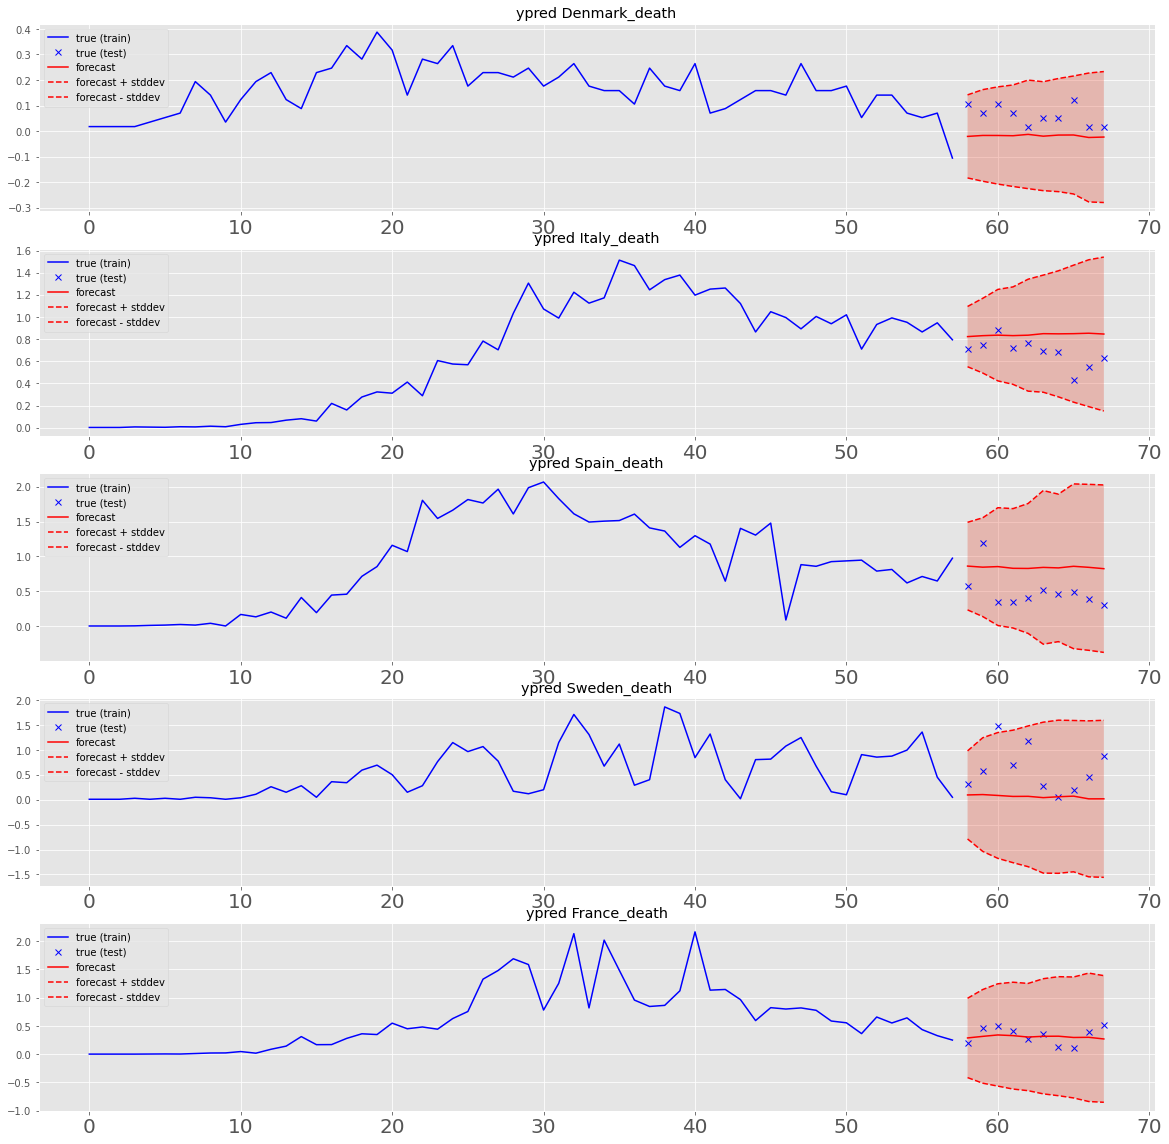

In [0]:
fig, axs = plt.subplots(nf_data,1, figsize=(20, 20))

axs = axs.ravel()

for i in range(nf_data):    

  Chooseplot = i+1
  if (Chooseplot==1):
    q=y_pred_1
  elif (Chooseplot==2):
    q=y_pred_2
  elif (Chooseplot==3):
    q=y_pred_3
  elif (Chooseplot==4):
    q=y_pred_4
  elif (Chooseplot==5):
    q=y_pred_5
  

  q_mean = q.mean(axis=0).reshape(-1,)
  q_std = q.std(axis=0).reshape(-1,)
  y_pred_025 = q_mean - 1.96*q_std
  y_pred_975 = q_mean + 1.96*q_std
  y_pred_mean = q_mean

  axs[i].plot(ix_train, y_train[:, Chooseplot-1], "b-")
  axs[i].plot(ix_test, y_test[:, Chooseplot-1], "bx")
  axs[i].plot(ix_test, y_pred_mean[-N_test:], "r-")
  axs[i].plot(ix_test, y_pred_025[-N_test:], "r--")
  axs[i].plot(ix_test, y_pred_975[-N_test:], "r--")
  axs[i].fill_between(ix_test, y_pred_025, y_pred_975, alpha=0.3)
  axs[i].legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])

  if(Chooseplot==1):
    plotname='Denmark_death'
  elif(Chooseplot==2):
    plotname='Italy_death'
  elif(Chooseplot==3):
    plotname='Spain_death'
  elif(Chooseplot==4):
    plotname='Sweden_death'
  elif(Chooseplot==5):
    plotname='France_death'
  
  axs[i].set_title("ypred "+ plotname)
 

Again, we see that the model are able to predict the COVID-19 deaths, but with a relatively large predicting interval. (Negative values should still not be possible for the predictions)

# LDS with C and $\Sigma $ and external covariates (OECD)

In the next model extension, we introduce external covariates that do not vary across timesteps. These covariates are the OECD-data presented above. Since they are static across all timesteps, we take them into account in the emission probabilities step. This is done by adding a weighted sum of the observed OECD variables to the weighted latent state. The new model graphically: 

![alt text](https://drive.google.com/uc?id=1T4pTk4gGBfWh85m2do62uaxkXjdu_D-k)

Again, unchanged latent dynamics:
\begin{align}
z_t &\sim \mathcal{N}(z_t|\beta z_{t-1}, \Sigma_1)\\
\end{align}

And new emission probabilities:
\begin{align}
y_t &\sim \mathcal{N}(y_t|Cz_t+Wx_{\tiny{OECD}}, \Sigma_2)
\end{align}

The predicted new daily deaths at timestep $t$ are now governed by the emission probabilities that is a normal distribution centered at $Cz_t+Ux_{\tiny{OECD}}$, allowing the external covariates from the OECD data to impact the predictions. The OECD-covariates are comparable in magnitude, since they are measured in deaths pr. 100.000 for each OECD health variable. Since the OECD variables are comparable, the coefficients in front of the variables will be comparable also - therefore, by assessing the differences in magnitude of the coefficients, we can learn something about the relative differences in importance between the OECD-variables in explaining COVID-19 deaths. 

Since we incorporate some new data, we start by re-loading the datasets.

In [0]:
data=pd.read_csv('/content/drive/My Drive/Modelbased ML Project/covid_and_externalvars_t0death.csv')

## Preprocessing of OECD data for input

To be able to incoporate the OECD data, the OECD data is saved in its own dataframe (x1). 

In [0]:
def first_last(df):
    return df.iloc[0:2]

In [0]:
x1=data[data['Country'].isin(['Denmark','Italy','Sweden','Spain','France'])][['Country','Total population', 'Acute_myocardial_infarction', 'Asthma',
       'Chronic_obstructive_Pulmonary_diseases', 'Diabetes_mellitus',
       'Diseases_of_the_respiratory_system', 'Influenza',
       'Ischaemic_heart_diseases', 'Pneumonia',
       'Population__65_years_old_and_over',
       'Population__80_years_old_and_over', 'Air_pollution',
       'Rooms_per_person', 'Number of people per household',
       'Single person households', 'Population__65_to_80_years_old']].groupby('Country').apply(first_last)

In [0]:
x1=x1.droplevel('Country')

In [0]:
x=[
   x1[x1['Country']=='Denmark'].iloc[0],
   x1[x1['Country']=='Italy'].iloc[0],
   x1[x1['Country']=='Spain'].iloc[0],
   x1[x1['Country']=='Sweden'].iloc[0],
   x1[x1['Country']=='France'].iloc[0],
]

In [0]:
x=pd.DataFrame(x).reset_index()

From the data we discard the "total population" and "Population__65_years_old_and_over":

In [0]:
x=x[[ 'Acute_myocardial_infarction', 'Asthma',
       'Chronic_obstructive_Pulmonary_diseases', 'Diabetes_mellitus',
       'Diseases_of_the_respiratory_system', 'Influenza',
       'Ischaemic_heart_diseases', 'Pneumonia',
       'Population__80_years_old_and_over', 'Air_pollution',
       'Rooms_per_person', 'Number of people per household',
       'Single person households', 'Population__65_to_80_years_old']]

The final OECD data is shown below. Each row represent the OECD data corresponding a country in the following order: Denmark, Italy, Spain, Sweden and France. 

## Merging COVID death time series

Merging each of the 5 countries timeseries.

In [0]:
#Selecting each contries time series
denmark = data[data["Country"] == "Denmark"]
denmark = denmark.reset_index()
italy=data[data["Country"] == "Italy"]
italy = italy.reset_index()
spain=data[data["Country"] == "Spain"]
spain = spain.reset_index()
sweden=data[data["Country"] == "Sweden"]
sweden = sweden.reset_index()
france=data[data["Country"] == "France"]
france = france.reset_index()

#Mering the data
two_countries=denmark.merge(italy,left_index=True,right_index=True,suffixes=('_denmark','_italy'))
three_countries=two_countries.merge(spain,left_index=True,right_index=True,suffixes=('','_spain')) #NB: The suffixes of spain doesnt work
four_countries=three_countries.merge(sweden,left_index=True,right_index=True,suffixes=('','_sweden'))
five_countries=four_countries.merge(france,left_index=True,right_index=True,suffixes=('','_france'))

Selecting COVID death from the data.

In [0]:
five_countries=five_countries[['Death_denmark','Death_italy','Death','Death_sweden','Death_france']]

In [0]:
df=five_countries

Train/test split

In [0]:
y = df.values
N, D = y.shape
print("N=%d, D=%d" % (N,D))

N=68, D=5


In [0]:
ix_train = range(0, 58) #This is chosen by us - when datasæt is "t0-data" then this doesnt matter
ix_test = range(58, 68)
N_train = len(ix_train)
N_test = len(ix_test)
print("N_train:", N_train)
print("N_test:", N_test)


# Selecting train and testdata
y_train = y[ix_train,:]
y_test = y[ix_test,:]

#Number of features (D)
nf_data = D #The number of timeseries to model (5)

N_train: 58
N_test: 10


Defining the carry function of the model. Now each of the OECD variables are added to the $y_t$'s with corresponding $W$ coefficient.

In [0]:
def f(carry, noise_list):
  beta, z_prev, tau, C, tau_2,x,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13 = carry
  z_t = beta*z_prev + noise_list[0] * tau
  y_t= C*z_t + noise_list[1] * tau_2 + W0*x[:,0] + W1* x[:,1] + W2* x[:,2] + W3* x[:,3] +  W4* x[:,4]  +  W5* x[:,5] +  W6* x[:,6]   + W7* x[:,7] + W8* x[:,8] + W9* x[:,9] +  W10* x[:,10]  +  W11* x[:,11] +  W12* x[:,12]+  W13* x[:,13] 
  z_prev = z_t
  return (beta, z_prev, tau,C,tau_2,x,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13), y_t

Defining the model. The new implementation is the sampling of the $W$ coefficent for the OECD variables.

In [0]:
from torch.distributions import constraints
import numpy

def model(T, T_forecast,nf = nf_data,n_forcast = 0, obs_matrix=None,x=None):
    
    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=jnp.ones(nf), scale=jnp.ones(nf)))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(nf)))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=2))

    z_prev = numpyro.sample(name="z_1", fn=dist.Normal(loc=jnp.ones(nf), scale=jnp.ones(nf)))
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(nf, 10.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(tau)), L_Omega) # lower cholesky factor of the covariance matrix
    noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(nf), scale_tril=Sigma_lower), sample_shape=(T+T_forecast-1,))
    
    #####Multivariate COVARIANCE######

    C = numpyro.sample(name="C", fn=dist.Normal(loc=jnp.ones(nf), scale=jnp.ones(nf)))

    tau_2 = numpyro.sample(name="tau_2", fn=dist.HalfCauchy(scale=jnp.ones(nf)))
    L_Omega_2 = numpyro.sample("L_Omega_2", dist.LKJCholesky(nf, 10.))
    Sigma_lower_2 = jnp.matmul(jnp.diag(jnp.sqrt(tau_2)), L_Omega_2)
    noises_2 = numpyro.sample("noises_2", fn=dist.MultivariateNormal(loc=jnp.zeros(nf), scale_tril=Sigma_lower_2), sample_shape=(T+T_forecast-1,))

    ##############OECD coefficients####################


    W0 = numpyro.sample(name="Acute_myocardial_infarction", fn=dist.Normal(loc=jnp.ones(nf)*0.01, scale=jnp.ones(nf)*1))
    W1 = numpyro.sample(name="Asthma", fn=dist.Normal(loc=jnp.ones(nf)*0.1, scale=jnp.ones(nf)*3))
    W2 = numpyro.sample(name="Chronic_obstructive_Pulmonary_diseases", fn=dist.Normal(loc=jnp.ones(nf)*0.01, scale=jnp.ones(nf)*1))
    W3 = numpyro.sample(name="Diabetes_mellitus", fn=dist.Normal(loc=jnp.ones(nf)*0.01, scale=jnp.ones(nf)*1))
    W4 = numpyro.sample(name="Diseases_of_the_respiratory_system", fn=dist.Normal(loc=jnp.ones(nf)*0.01, scale=jnp.ones(nf)*1))
    W5 = numpyro.sample(name="Influenza", fn=dist.Normal(loc=jnp.ones(nf)*0.1, scale=jnp.ones(nf)*3))
    W6 = numpyro.sample(name="Ischaemic_heart_diseases", fn=dist.Normal(loc=jnp.ones(nf)*0.01, scale=jnp.ones(nf)*1))
    W7 = numpyro.sample(name="Pneumonia", fn=dist.Normal(loc=jnp.ones(nf)*0.01, scale=jnp.ones(nf)*1))
    W8 = numpyro.sample(name="Population__80_years_old_and_over", fn=dist.Normal(loc=jnp.ones(nf)*0.1, scale=jnp.ones(nf)*3))
    W9 = numpyro.sample(name="Air_pollution", fn=dist.Normal(loc=jnp.ones(nf)*0.1, scale=jnp.ones(nf)*3))
    W10 = numpyro.sample(name="Rooms_per_person", fn=dist.Normal(loc=jnp.ones(nf)*0.1, scale=jnp.ones(nf)*3))
    W11 = numpyro.sample(name="Number of people per household", fn=dist.Normal(loc=jnp.ones(nf)*0.1, scale=jnp.ones(nf)*3))
    W12 = numpyro.sample(name="Single person households", fn=dist.Normal(loc=jnp.ones(nf)*0.01, scale=jnp.ones(nf)*1))
    W13 = numpyro.sample(name="Population__65_to_80_years_old", fn=dist.Normal(loc=jnp.ones(nf)*0.1, scale=jnp.ones(nf)*1))


    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, z_prev, tau, C, tau_2,x,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13)
    y_collection=[z_prev]
    carry, ys_exp = lax.scan(f, carry, [noises,noises_2], T+T_forecast-1) 
    y_collection = jnp.concatenate((jnp.array(y_collection), ys_exp), axis=0)


    
    numpyro.sample(name="y_obs_death_denmark", fn=dist.Normal(loc=y_collection[:T,0], scale=sigma), obs=obs_matrix[:,0])
    numpyro.sample(name="y_obs_death_italy", fn=dist.Normal(loc=y_collection[:T,1], scale=sigma), obs=obs_matrix[:,1])
    numpyro.sample(name="y_obs_death_spain", fn=dist.Normal(loc=y_collection[:T,2], scale=sigma), obs=obs_matrix[:,2])
    numpyro.sample(name="y_obs_death_sweden", fn=dist.Normal(loc=y_collection[:T,3], scale=sigma), obs=obs_matrix[:,3])
    numpyro.sample(name="y_obs_death_france", fn=dist.Normal(loc=y_collection[:T,4], scale=sigma), obs=obs_matrix[:,4])
    


    if (n_forcast > 0): 
      numpyro.sample(name="y_pred_death_denmark", fn=dist.Normal(loc=y_collection[T:,0], scale=sigma), obs=None)
      numpyro.sample(name="y_pred_death_italy", fn=dist.Normal(loc=y_collection[T:,1], scale=sigma), obs=None)
      numpyro.sample(name="y_pred_death_spain", fn=dist.Normal(loc=y_collection[T:,2], scale=sigma), obs=None)
      numpyro.sample(name="y_pred_death_sweden", fn=dist.Normal(loc=y_collection[T:,3], scale=sigma), obs=None)
      numpyro.sample(name="y_pred_death_france", fn=dist.Normal(loc=y_collection[T:,4], scale=sigma), obs=None)

MCMC Inference


In [0]:
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model, step_size=5e-2, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=N_train, T_forecast=N_test, obs_matrix=y_train,x=x.values) 
t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 4000/4000 [08:55<00:00,  7.47it/s, 1023 steps of size 1.65e-04. acc. prob=0.91]


Total time: 11.316m


In [0]:
mcmc.print_summary()


                                               mean       std    median      5.0%     95.0%     n_eff     r_hat
           Acute_myocardial_infarction[0]      0.05      0.93      0.08     -1.42      1.25      2.59      3.48
           Acute_myocardial_infarction[1]     -0.26      0.60     -0.33     -1.10      0.89     14.23      1.00
           Acute_myocardial_infarction[2]      0.59      0.66      0.70     -0.76      1.42      4.09      1.64
           Acute_myocardial_infarction[3]     -0.40      0.43     -0.42     -0.98      0.41      8.73      1.03
           Acute_myocardial_infarction[4]      0.79      0.29      0.65      0.48      1.35      3.62      1.47
                         Air_pollution[0]     -3.06      1.89     -2.86     -6.51     -0.67      3.75      1.62
                         Air_pollution[1]      1.11      2.18      1.98     -2.93      3.51      3.00      1.95
                         Air_pollution[2]      0.09      1.54      0.17     -2.01      2.90      3.68  

The $rhat$ values are relativelly high. The MCMC model might not be tuned properly which is typically a challenge with MCMC models.

In [0]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

Inspecting trace-plots.

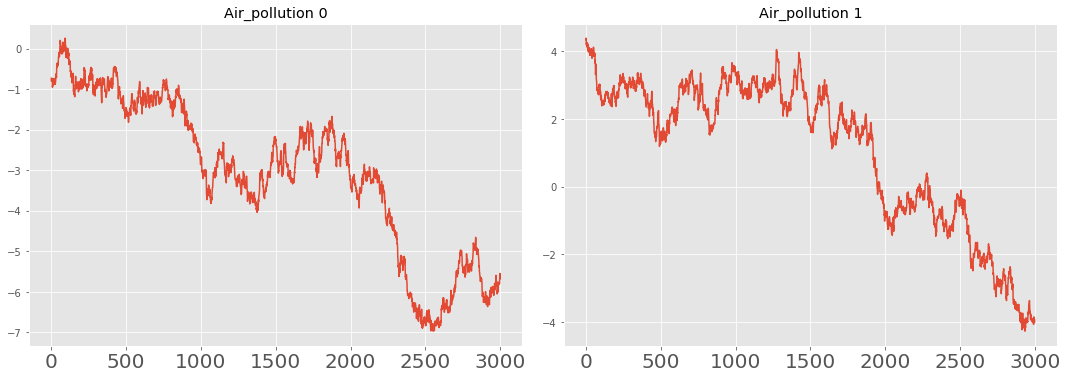

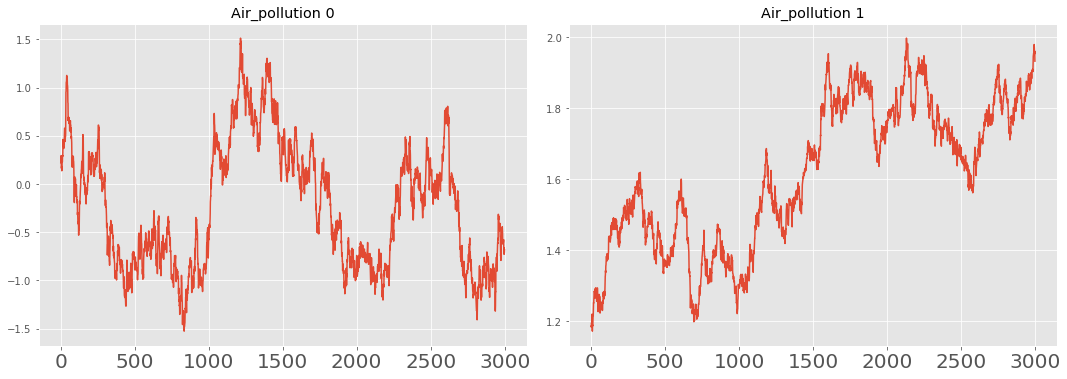

In [0]:
plt.figure(figsize=(15,10))
for i in range(2):
    ax=plt.subplot(2,2,i+1)
    plt.plot(pd.DataFrame(hmc_samples['Air_pollution'][:,i]))
    
    plt.title("Air_pollution "+str(i))
    #plt.setp(ax.get_xticklabels(), rotation=45)    
plt.tight_layout()
plt.show(ax)

plt.figure(figsize=(15,10))
for i in range(2):
    ax=plt.subplot(2,2,i+1)
    plt.plot(pd.DataFrame(hmc_samples['Population__65_to_80_years_old'][:,i]))
    
    plt.title("Air_pollution "+str(i))
    #plt.setp(ax.get_xticklabels(), rotation=45)    
plt.tight_layout()
plt.show(ax)




The traceplot of the Air Polution indicates that the model could benefit from increasing the number of iterations. It seems more unstable (less converged) than the previous models. In an attempt to alleviate this problem, we tried running the model using 10.000 iterations (in an alternative script) which did not lead to an improvement in performance - it still appeared that the model did not converge.

Plotting the distribution of the model variables.

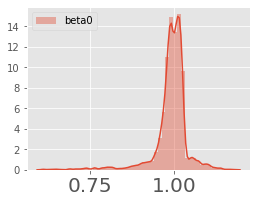

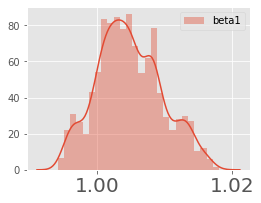

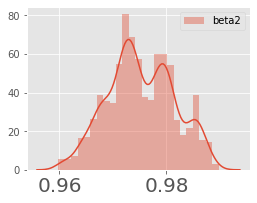

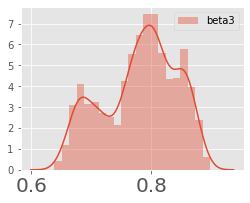

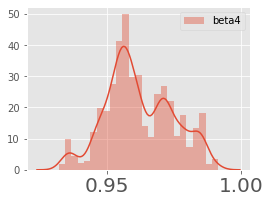

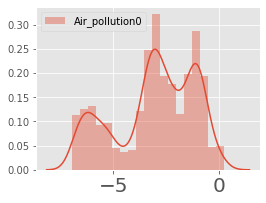

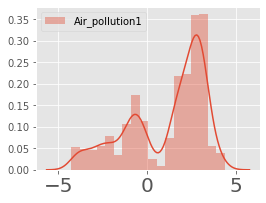

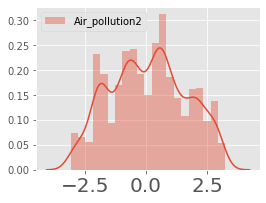

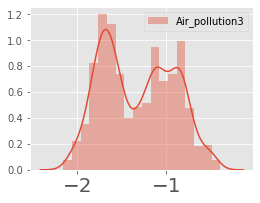

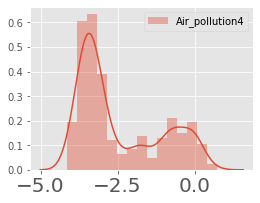

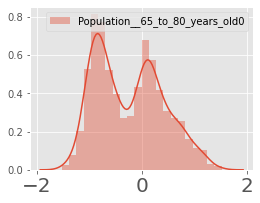

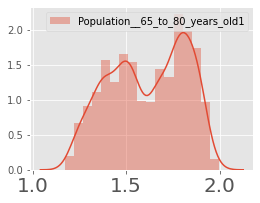

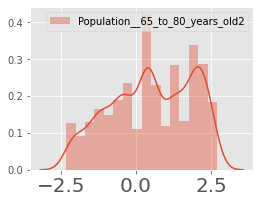

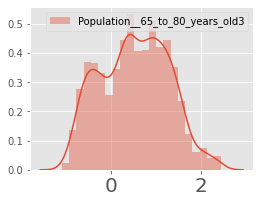

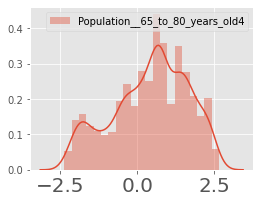

In [0]:
nodes = ["beta", "Air_pollution","Population__65_to_80_years_old"]
for node in nodes:
  if node == "beta" or node=='Air_pollution'  or node=="Population__65_to_80_years_old":
    for i in range(nf_data):
      plt.figure(figsize=(4,3))
      sns.distplot(hmc_samples[node][:,i], label=node+"%d"%i)
      plt.legend()
    plt.show()
  else:
    plt.figure(figsize=(4,3))
    sns.distplot(hmc_samples[node], label=node)
    plt.legend()
    plt.show()

The distributions of the OECD variables look multimodal.

Predicting COVID death for the each of the countries' COVID death time series.

In [0]:
rng_key = random.PRNGKey(0)
predictive = Predictive(model,posterior_samples=mcmc.get_samples())
y_pred_1 = predictive(rng_key,T=N_train, T_forecast=N_test,n_forcast = 10,obs_matrix=y_train,x=x.values)["y_pred_death_denmark"]
y_pred_2 = predictive(rng_key,T=N_train, T_forecast=N_test,n_forcast = 10,obs_matrix=y_train,x=x.values)["y_pred_death_italy"]
y_pred_3 = predictive(rng_key,T=N_train, T_forecast=N_test,n_forcast = 10,obs_matrix=y_train,x=x.values)["y_pred_death_spain"]
y_pred_4 = predictive(rng_key,T=N_train, T_forecast=N_test,n_forcast = 10,obs_matrix=y_train,x=x.values)["y_pred_death_sweden"]
y_pred_5 = predictive(rng_key,T=N_train, T_forecast=N_test,n_forcast = 10,obs_matrix=y_train,x=x.values)["y_pred_death_france"]

Calculating model average MSE

In [0]:
from sklearn.metrics import mean_squared_error

#calculating mean of predictions for each timeseries
mean_preds_1_M3=y_pred_1.mean(axis=0).reshape(-1,) 
mean_preds_2_M3=y_pred_2.mean(axis=0).reshape(-1,)
mean_preds_3_M3=y_pred_3.mean(axis=0).reshape(-1,)
mean_preds_4_M3=y_pred_4.mean(axis=0).reshape(-1,)
mean_preds_5_M3=y_pred_5.mean(axis=0).reshape(-1,)

# calulating MSE for each timeseries on the test set
MSE1_M3=mean_squared_error(y_test.T[[0][0]], mean_preds_1_M3)
MSE2_M3=mean_squared_error(y_test.T[[1][0]], mean_preds_2_M3)
MSE3_M3=mean_squared_error(y_test.T[[2][0]], mean_preds_3_M3)
MSE4_M3=mean_squared_error(y_test.T[[3][0]], mean_preds_4_M3)
MSE5_M3=mean_squared_error(y_test.T[[4][0]], mean_preds_5_M3) 

# calculating the average of time series MSE, finding estimate of model MSE
model_avg_MSE_M3 = np.mean([MSE1_M3,MSE2_M3,MSE3_M3,MSE4_M3,MSE5_M3])
model_avg_MSE_M3

0.14934779443808277

In [0]:
print(MSE1_M3)
print(MSE2_M3)
print(MSE3_M3)
print(MSE4_M3)
print(MSE5_M3)

0.002346871846144828
0.01786826429784336
0.16358137023562264
0.4354547524862985
0.12748771332450454


The performance of the model has not been improved by adding the OECD data. Since the model performance does not improve we wont pursue asnwering one of the stated purposes of the project - which was to compare and evaluate theories regarding what impacts the variance in COVID-19 mobility between countries/regions. These theories would more likely be easier to test if more data were available. The subset of countries included in the model can also affect the results - and by including more countries might lead to better results.

Finally, we plot the prediction of the model to visually asses the performance as well. 

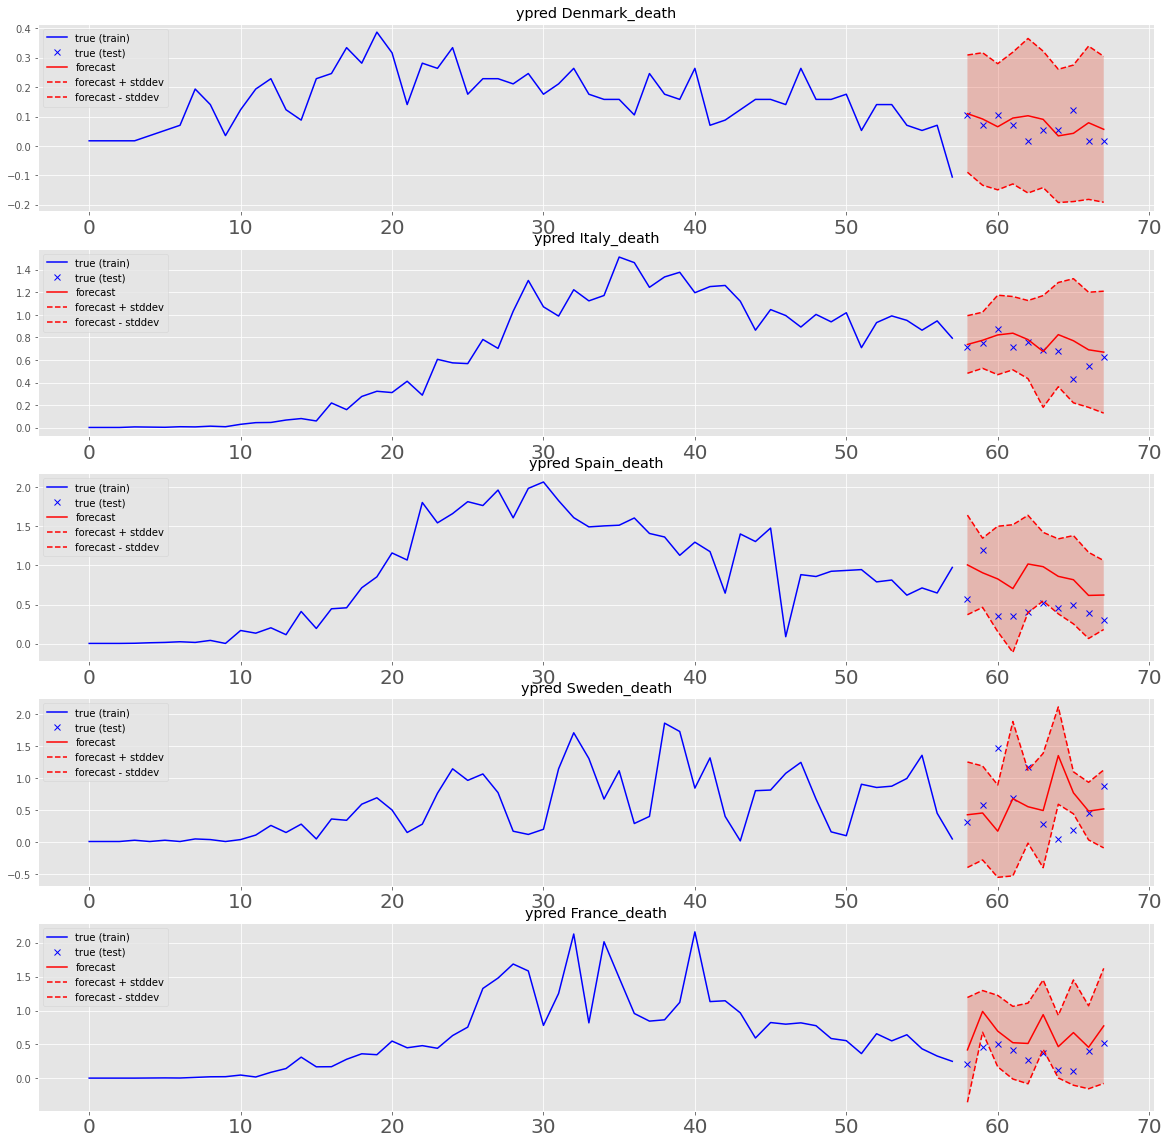

In [0]:
fig, axs = plt.subplots(nf_data,1, figsize=(20, 20))

axs = axs.ravel()

for i in range(nf_data):
    
  
  Chooseplot = i+1
  if (Chooseplot==1):
    q=y_pred_1
  elif (Chooseplot==2):
    q=y_pred_2
  elif (Chooseplot==3):
    q=y_pred_3
  elif (Chooseplot==4):
    q=y_pred_4
  elif (Chooseplot==5):
    q=y_pred_5
  

  q_mean = q.mean(axis=0).reshape(-1,)
  q_std = q.std(axis=0).reshape(-1,)
  y_pred_025 = q_mean - 1.96*q_std
  y_pred_975 = q_mean + 1.96*q_std
  y_pred_mean = q_mean

  axs[i].plot(ix_train, y_train[:, Chooseplot-1], "b-")
  axs[i].plot(ix_test, y_test[:, Chooseplot-1], "bx")
  axs[i].plot(ix_test, y_pred_mean[-N_test:], "r-")
  axs[i].plot(ix_test, y_pred_025[-N_test:], "r--")
  axs[i].plot(ix_test, y_pred_975[-N_test:], "r--")
  axs[i].fill_between(ix_test, y_pred_025, y_pred_975, alpha=0.3)
  axs[i].legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])

  if(Chooseplot==1):
    plotname='Denmark_death'
  elif(Chooseplot==2):
    plotname='Italy_death'
  elif(Chooseplot==3):
    plotname='Spain_death'
  elif(Chooseplot==4):
    plotname='Sweden_death'
  elif(Chooseplot==5):
    plotname='France_death'
  

  axs[i].set_title("ypred "+ plotname)
 

As seen the predictions are following the true points somewhat reasonably, however still with larger deviations. As seen in the prediction intervals, the model is still subject to large uncertainty.

# LDS with C and $\Sigma $ and external covariates (OECD) + (Google)

In the final model extension, we introduce external covariates that vary across timesteps. These covariates are the Google Mobility data presented above. Since they vary across timesteps, we take them into account in the transition probabilities between the latent states. This is done by adding a weighted sum of the observed OECD variables to the weighted previous latent state. The new model graphically: 

![alt text](https://drive.google.com/uc?id=1v6aurfPzcovwWKlhMv8pJbX5qqV2C_xW)

The new latent dynamics:
\begin{align}
z_t &\sim \mathcal{N}(z_t|\beta z_{t-1}+Gx_{\tiny{Google}}, \Sigma_1)\\
\end{align}

And unchanged emission probabilities:
\begin{align}
y_t &\sim \mathcal{N}(y_t|Cz_t+Wx_{\tiny{OECD}}, \Sigma_2)
\end{align}

The auto-regressive dynamics between the latent states now take into account $Gx_{\tiny{Google}}$, allowing the external covariates from the Google Mobility data to impact the transition probabilities between the latent states. This data models the effect of social distancing on the morbidity of COVID-19. Since most governments around the world have relied heavily on social distancing measures, it is interesting to see if the model performs better when we include this data. Also, it could be interesting to compare the G-coefficients for Sweden with the other countries, since Sweden - infamously - has had less severe restrictions than the other countries in our dataset. 

Lets start by loading the datasets.

In [0]:
data=pd.read_csv('/content/drive/My Drive/Modelbased ML Project/covid_and_externalvars_t0death.csv')

## Preprocessing OECD data

In [0]:
def first_last(df):
    return df.iloc[0:2]

In [0]:
x1=data[data['Country'].isin(['Denmark','Italy','Sweden','Spain','France'])][['Country','Total population', 'Acute_myocardial_infarction', 'Asthma',
       'Chronic_obstructive_Pulmonary_diseases', 'Diabetes_mellitus',
       'Diseases_of_the_respiratory_system', 'Influenza',
       'Ischaemic_heart_diseases', 'Pneumonia',
       'Population__65_years_old_and_over',
       'Population__80_years_old_and_over', 'Air_pollution',
       'Rooms_per_person', 'Number of people per household',
       'Single person households', 'Population__65_to_80_years_old']].groupby('Country').apply(first_last)

In [0]:
x1=x1.droplevel('Country')


In [0]:
x=[
   x1[x1['Country']=='Denmark'].iloc[0],
   x1[x1['Country']=='Italy'].iloc[0],
   x1[x1['Country']=='Spain'].iloc[0],
   x1[x1['Country']=='Sweden'].iloc[0],
   x1[x1['Country']=='France'].iloc[0],
]

In [0]:
x=pd.DataFrame(x).reset_index()

In [0]:
x=x[[ 'Acute_myocardial_infarction', 'Asthma',
       'Chronic_obstructive_Pulmonary_diseases', 'Diabetes_mellitus',
       'Diseases_of_the_respiratory_system', 'Influenza',
       'Ischaemic_heart_diseases', 'Pneumonia',
       'Population__80_years_old_and_over', 'Air_pollution',
       'Rooms_per_person', 'Number of people per household',
       'Single person households', 'Population__65_to_80_years_old']]

## Merging data

Merging data.

In [0]:
denmark = data[data["Country"] == "Denmark"]
denmark = denmark.reset_index()
italy=data[data["Country"] == "Italy"]
italy = italy.reset_index()

spain=data[data["Country"] == "Spain"]
spain = spain.reset_index()


sweden=data[data["Country"] == "Sweden"]
sweden = sweden.reset_index()

france=data[data["Country"] == "France"]
france = france.reset_index()

two_countries=denmark.merge(italy,left_index=True,right_index=True,suffixes=('_denmark','_italy'))


#####The suffixes does not work!!!!!######
three_countries=two_countries.merge(spain,left_index=True,right_index=True,suffixes=('','_spain'))


four_countries=three_countries.merge(sweden,left_index=True,right_index=True,suffixes=('','_sweden'))

five_countries=four_countries.merge(france,left_index=True,right_index=True,suffixes=('','_france'))

## Preprocessing Google data

Lag 23 is the data which should be used for be the input variable.

In [0]:
x_google=five_countries[
 [
  #Denmark Google data
'Confirmed_denmark',
'retail_and_recreation_percent_change_from_baseline_Lag_23_denmark',
'grocery_and_pharmacy_percent_change_from_baseline_Lag_23_denmark',
'parks_percent_change_from_baseline_Lag_23_denmark',
'transit_stations_percent_change_from_baseline_Lag_23_denmark',
'workplaces_percent_change_from_baseline_Lag_23_denmark',
'residential_percent_change_from_baseline_Lag_23_denmark',

#Italy google data
'Confirmed_italy',
'retail_and_recreation_percent_change_from_baseline_Lag_23_italy',
'grocery_and_pharmacy_percent_change_from_baseline_Lag_23_italy',
'parks_percent_change_from_baseline_Lag_23_italy',
'transit_stations_percent_change_from_baseline_Lag_23_italy',
'workplaces_percent_change_from_baseline_Lag_23_italy',
'residential_percent_change_from_baseline_Lag_23_italy',

#spain google data
'Confirmed',
'retail_and_recreation_percent_change_from_baseline_Lag_23',
'grocery_and_pharmacy_percent_change_from_baseline_Lag_23',
'parks_percent_change_from_baseline_Lag_23',
'transit_stations_percent_change_from_baseline_Lag_23',
'workplaces_percent_change_from_baseline_Lag_23',
'residential_percent_change_from_baseline_Lag_23',

#sweden google data
'Confirmed_sweden',
'retail_and_recreation_percent_change_from_baseline_Lag_23_sweden',
'grocery_and_pharmacy_percent_change_from_baseline_Lag_23_sweden',
'parks_percent_change_from_baseline_Lag_23_sweden',
'transit_stations_percent_change_from_baseline_Lag_23_sweden',
'workplaces_percent_change_from_baseline_Lag_23_sweden',
'residential_percent_change_from_baseline_Lag_23_sweden',

#france google data
'Confirmed_france',
'retail_and_recreation_percent_change_from_baseline_Lag_23_france',
'grocery_and_pharmacy_percent_change_from_baseline_Lag_23_france',
'parks_percent_change_from_baseline_Lag_23_france',
'transit_stations_percent_change_from_baseline_Lag_23_france',
'workplaces_percent_change_from_baseline_Lag_23_france',
'residential_percent_change_from_baseline_Lag_23_france'


 ]         
]

Saving each Google variable across the countries as their own dataframe.

In [0]:
x_goog0=x_google.iloc[:,[0,7,14,21,28]].values[:] #confirmed  
x_goog1=x_google.iloc[:,[0+1,7+1,14+1,21+1,28+1]].values[:] #retail
x_goog2=x_google.iloc[:,[0+2,7+2,14+2,21+2,28+2]].values[:] #grocery 
x_goog3=x_google.iloc[:,[0+3,7+3,14+3,21+3,28+3]].values[:] #parks 
x_goog4=x_google.iloc[:,[0+4,7+4,14+4,21+4,28+4]].values[:] #stations 
x_goog5=x_google.iloc[:,[0+5,7+5,14+5,21+5,28+5]].values[:] #workplaces 
x_goog6=x_google.iloc[:,[0+6,7+6,14+6,21+6,28+6]].values[:] #residental 


## Preprocessing Death time series

Keeping the COVID deaths.

In [0]:
five_countries=five_countries[['Death_denmark','Death_italy','Death','Death_sweden','Death_france']]

In [0]:
df=five_countries

## Denmark, Italy, Spain, Sweden and France

In [0]:
y = df.values
N, D = y.shape
print("N=%d, D=%d" % (N,D))

N=68, D=5


In [0]:
ix_train = range(0, 58) #This is chosen by us - when datasæt is "t0-data" then this doesnt matter
ix_test = range(58, 68)
N_train = len(ix_train)
N_test = len(ix_test)
print("N_train:", N_train)
print("N_test:", N_test)


# Select train and test
y_train = y[ix_train,:]
y_test = y[ix_test,:]

#Number of features (D)
nf_data = D #Number of time series

N_train: 58
N_test: 10


The carry function for the model. Now the google data is added to the hidden state mean. G0 is the coefficient for the "Confirmed COVID cases". G1, G2, G3, G4, G5 and G6 are the coeffiencts for the google data.

In [0]:
def f(carry, noise_list):
  beta, z_prev, tau, C, tau_2,x,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,x_g0,x_g1,x_g2,x_g3,x_g4,x_g5,x_g6,idx,G0,G1,G2,G3,G4,G5,G6 = carry
  
  z_t = beta*z_prev + noise_list[0] * tau + G0*x_g0[idx]+G1*x_g1[idx]+G2*x_g2[idx]+G3*x_g3[idx]+G4*x_g4[idx]+G5*x_g5[idx]+G6*x_g6[idx]
  

  y_t= C*z_t + noise_list[1] * tau_2 + W0*x[:,0] + W1* x[:,1] + W2* x[:,2] + W3* x[:,3] +  W4* x[:,4]  +  W5* x[:,5] +  W6* x[:,6]   + W7* x[:,7] + W8* x[:,8] + W9* x[:,9] +  W10* x[:,10]  +  W11* x[:,11] +  W12* x[:,12]+  W13* x[:,13] 
  z_prev = z_t
  idx=idx+1
  return (beta, z_prev, tau,C,tau_2,x,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,x_g0,x_g1,x_g2,x_g3,x_g4,x_g5,x_g6,idx,G0,G1,G2,G3,G4,G5,G6), y_t

Define the model. The new implementation is the G-coefficients and input google data.


In [0]:
from torch.distributions import constraints
import numpy

def model(T, T_forecast,nf = nf_data,n_forcast = 0, obs_matrix=None,x=None,x_g0=None,x_g1=None,x_g2=None,x_g3=None,x_g4=None,x_g5=None,x_g6=None):
    
    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=jnp.ones(nf), scale=jnp.ones(nf)))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(nf)))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=2))

    z_prev = numpyro.sample(name="z_1", fn=dist.Normal(loc=jnp.ones(nf), scale=jnp.ones(nf)))
    # Define LKJ prior
    L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(nf, 10.))
    Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(tau)), L_Omega) # lower cholesky factor of the covariance matrix
    noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(nf), scale_tril=Sigma_lower), sample_shape=(T+T_forecast-1,))
    
    #####Multivariate COVARIANCE######

    C = numpyro.sample(name="C", fn=dist.Normal(loc=jnp.ones(nf), scale=jnp.ones(nf)))

    tau_2 = numpyro.sample(name="tau_2", fn=dist.HalfCauchy(scale=jnp.ones(nf)))
    L_Omega_2 = numpyro.sample("L_Omega_2", dist.LKJCholesky(nf, 10.))
    Sigma_lower_2 = jnp.matmul(jnp.diag(jnp.sqrt(tau_2)), L_Omega_2)
    noises_2 = numpyro.sample("noises_2", fn=dist.MultivariateNormal(loc=jnp.zeros(nf), scale_tril=Sigma_lower_2), sample_shape=(T+T_forecast-1,))

    ##################################

    ###########OECD###########
    W0 = numpyro.sample(name="Acute_myocardial_infarction", fn=dist.Normal(loc=jnp.zeros(nf)*0.01, scale=jnp.ones(nf)*1))
    W1 = numpyro.sample(name="Asthma", fn=dist.Normal(loc=jnp.zeros(nf)*0.1, scale=jnp.ones(nf)*3))
    W2 = numpyro.sample(name="Chronic_obstructive_Pulmonary_diseases", fn=dist.Normal(loc=jnp.zeros(nf)*0.01, scale=jnp.ones(nf)*1))
    W3 = numpyro.sample(name="Diabetes_mellitus", fn=dist.Normal(loc=jnp.zeros(nf)*0.01, scale=jnp.ones(nf)*1))
    W4 = numpyro.sample(name="Diseases_of_the_respiratory_system", fn=dist.Normal(loc=jnp.zeros(nf)*0.01, scale=jnp.ones(nf)*1))
    W5 = numpyro.sample(name="Influenza", fn=dist.Normal(loc=jnp.zeros(nf)*0.1, scale=jnp.ones(nf)*3))
    W6 = numpyro.sample(name="Ischaemic_heart_diseases", fn=dist.Normal(loc=jnp.zeros(nf)*0.01, scale=jnp.ones(nf)*1))
    W7 = numpyro.sample(name="Pneumonia", fn=dist.Normal(loc=jnp.zeros(nf)*0.01, scale=jnp.ones(nf)*1))
    W8 = numpyro.sample(name="Population__80_years_old_and_over", fn=dist.Normal(loc=jnp.zeros(nf)*0.1, scale=jnp.ones(nf)*3))
    W9 = numpyro.sample(name="Air_pollution", fn=dist.Normal(loc=jnp.zeros(nf)*0.1, scale=jnp.ones(nf)*3))
    W10 = numpyro.sample(name="Rooms_per_person", fn=dist.Normal(loc=jnp.zeros(nf)*0.1, scale=jnp.ones(nf)*3))
    W11 = numpyro.sample(name="Number of people per household", fn=dist.Normal(loc=jnp.zeros(nf)*0.1, scale=jnp.ones(nf)*3))
    W12 = numpyro.sample(name="Single person households", fn=dist.Normal(loc=jnp.zeros(nf)*0.01, scale=jnp.ones(nf)*1))
    W13 = numpyro.sample(name="Population__65_to_80_years_old", fn=dist.Normal(loc=jnp.zeros(nf)*0.1, scale=jnp.ones(nf)*1))
    

    #######google#####
    G0 = numpyro.sample(name="G_confirmed", fn=dist.Normal(loc=jnp.zeros(nf)+0.005, scale=jnp.ones(nf)*0.5))
    G1 = numpyro.sample(name="G_retail", fn=dist.Normal(loc=jnp.zeros(nf)+0.005, scale=jnp.ones(nf)*0.5))
    G2 = numpyro.sample(name="G_grocery", fn=dist.Normal(loc=jnp.zeros(nf)+0.005, scale=jnp.ones(nf)*0.5))
    G3 = numpyro.sample(name="G_parks", fn=dist.Normal(loc=jnp.zeros(nf)+0.005, scale=jnp.ones(nf)*0.5))
    G4 = numpyro.sample(name="G_stations", fn=dist.Normal(loc=jnp.zeros(nf)+0.005, scale=jnp.ones(nf)*0.5))
    G5 = numpyro.sample(name="G_workplaces", fn=dist.Normal(loc=jnp.zeros(nf)+0.005, scale=jnp.ones(nf)*0.5))
    G6 = numpyro.sample(name="G_residentials", fn=dist.Normal(loc=jnp.zeros(nf)-0.005, scale=jnp.ones(nf)*0.5))

    ########################
    idx=0
    # Propagate the dynamics forward using jax.lax.scan
    carry = (beta, z_prev, tau, C, tau_2,x,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,x_g0,x_g1,x_g2,x_g3,x_g4,x_g5,x_g6,idx,G0,G1,G2,G3,G4,G5,G6)
    y_collection=[z_prev]
    carry, ys_exp = lax.scan(f, carry, [noises,noises_2], T+T_forecast-1) 
    y_collection = jnp.concatenate((jnp.array(y_collection), ys_exp), axis=0)


    
    numpyro.sample(name="y_obs_death_denmark", fn=dist.Normal(loc=y_collection[:T,0], scale=sigma), obs=obs_matrix[:,0])
    numpyro.sample(name="y_obs_death_italy", fn=dist.Normal(loc=y_collection[:T,1], scale=sigma), obs=obs_matrix[:,1])
    numpyro.sample(name="y_obs_death_spain", fn=dist.Normal(loc=y_collection[:T,2], scale=sigma), obs=obs_matrix[:,2])
    numpyro.sample(name="y_obs_death_sweden", fn=dist.Normal(loc=y_collection[:T,3], scale=sigma), obs=obs_matrix[:,3])
    numpyro.sample(name="y_obs_death_france", fn=dist.Normal(loc=y_collection[:T,4], scale=sigma), obs=obs_matrix[:,4])
    


    if (n_forcast > 0): 
      numpyro.sample(name="y_pred_death_denmark", fn=dist.Normal(loc=y_collection[T:,0], scale=sigma), obs=None)
      numpyro.sample(name="y_pred_death_italy", fn=dist.Normal(loc=y_collection[T:,1], scale=sigma), obs=None)
      numpyro.sample(name="y_pred_death_spain", fn=dist.Normal(loc=y_collection[T:,2], scale=sigma), obs=None)
      numpyro.sample(name="y_pred_death_sweden", fn=dist.Normal(loc=y_collection[T:,3], scale=sigma), obs=None)
      numpyro.sample(name="y_pred_death_france", fn=dist.Normal(loc=y_collection[T:,4], scale=sigma), obs=None)

MCMC Inference


In [0]:
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model, step_size=5e-2, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=N_train, T_forecast=N_test, obs_matrix=y_train,x=x.values,
         x_g0=x_goog0[ix_train,:],
         x_g1=x_goog1[ix_train,:],
         x_g2=x_goog2[ix_train,:],
         x_g3=x_goog3[ix_train,:],
         x_g4=x_goog4[ix_train,:],
         x_g5=x_goog5[ix_train,:],
         x_g6=x_goog6[ix_train,:]) 
t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 4000/4000 [11:28<00:00,  5.81it/s, 1023 steps of size 1.58e-04. acc. prob=0.92]


Total time: 15.024m


In [0]:
mcmc.print_summary()


                                               mean       std    median      5.0%     95.0%     n_eff     r_hat
           Acute_myocardial_infarction[0]     -0.17      0.36     -0.21     -0.67      0.44      2.82      1.95
           Acute_myocardial_infarction[1]     -0.27      0.64     -0.26     -1.40      0.86      7.40      1.29
           Acute_myocardial_infarction[2]      0.01      0.81     -0.06     -1.34      1.18      2.97      2.28
           Acute_myocardial_infarction[3]     -1.04      0.50     -1.15     -1.74     -0.33      4.09      1.13
           Acute_myocardial_infarction[4]     -0.78      0.69     -0.81     -1.78      0.28     11.61      1.05
                         Air_pollution[0]     -0.70      1.45     -0.38     -3.24      1.18      6.53      2.02
                         Air_pollution[1]      1.12      0.53      1.06      0.45      2.14      6.03      1.00
                         Air_pollution[2]      2.40      2.17      1.94     -0.59      5.89      4.92  

In [0]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

Plotting the distribution of the model variables. 

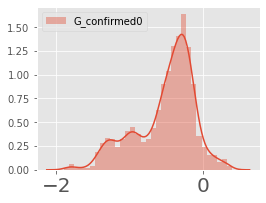

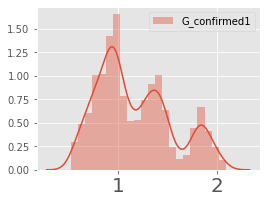

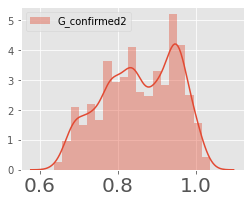

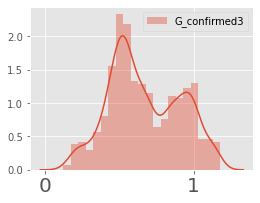

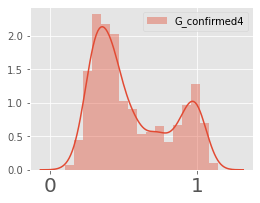

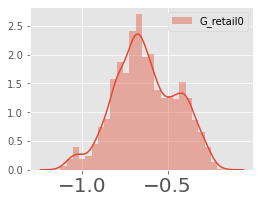

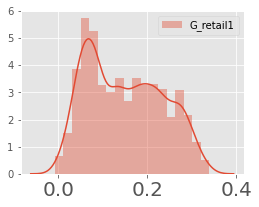

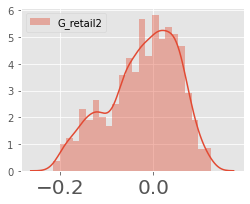

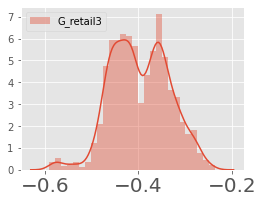

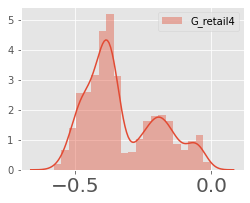

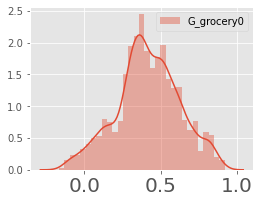

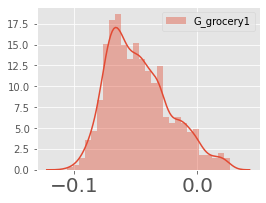

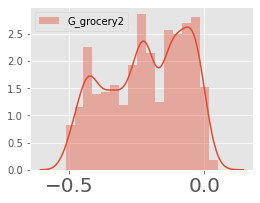

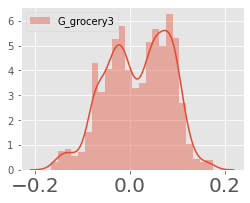

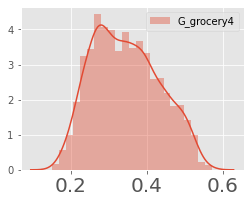

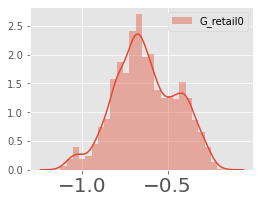

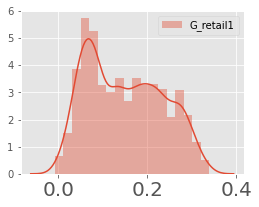

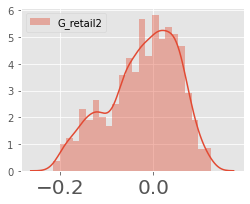

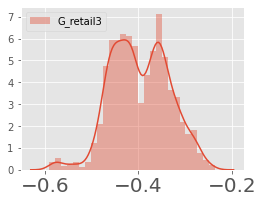

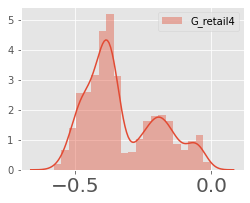

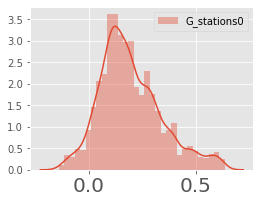

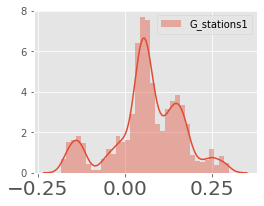

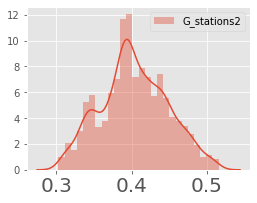

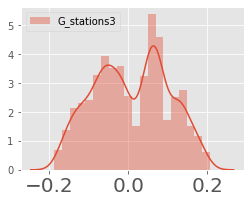

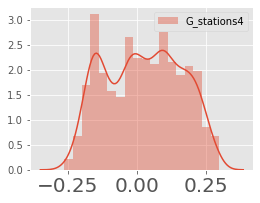

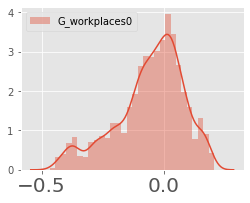

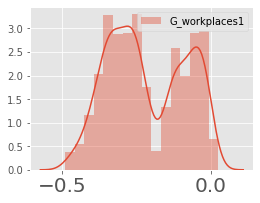

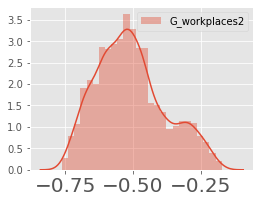

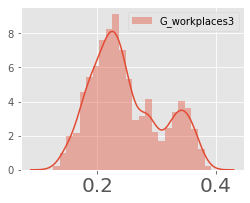

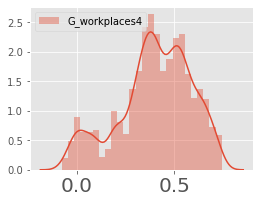

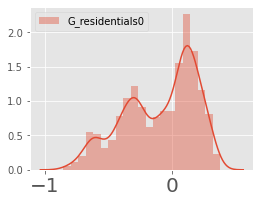

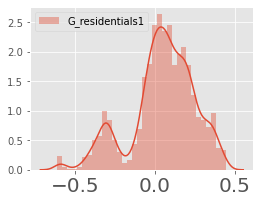

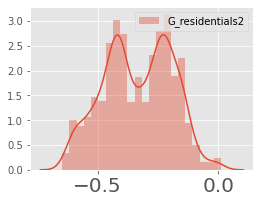

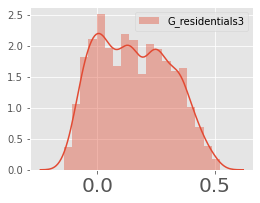

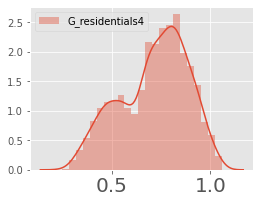

In [0]:
nodes = ["G_confirmed","G_retail","G_grocery","G_retail","G_stations","G_workplaces","G_residentials"]
for node in nodes:
    for i in range(nf_data):
      plt.figure(figsize=(4,3))
      sns.distplot(hmc_samples[node][:,i], label=node+"%d"%i)
      plt.legend()
    plt.show()
 

From the distributionsplots it seems that there are multimodality. Additionally we see that the variables vary a lot from country to country. It is hard to conclude how the variables affect the COVID-19 deaths. 

Using the predictive class to predict COVID death for the 5 countries.

In [0]:
from numpyro.infer import Predictive
rng_key = random.PRNGKey(0)
predictive = Predictive(model,posterior_samples=mcmc.get_samples())
y_pred_1 = predictive(rng_key,T=N_train, T_forecast=N_test,n_forcast = 10,obs_matrix=y_train,x=x.values,
                       x_g0=x_goog0[ix_train,:],
         x_g1=x_goog1[ix_train,:],
         x_g2=x_goog2[ix_train,:],
         x_g3=x_goog3[ix_train,:],
         x_g4=x_goog4[ix_train,:],
         x_g5=x_goog5[ix_train,:],
         x_g6=x_goog6[ix_train,:])["y_pred_death_denmark"]

y_pred_2 = predictive(rng_key,T=N_train, T_forecast=N_test,n_forcast = 10,obs_matrix=y_train,x=x.values,x_g0=x_goog0[ix_train,:],
         x_g1=x_goog1[ix_train,:],
         x_g2=x_goog2[ix_train,:],
         x_g3=x_goog3[ix_train,:],
         x_g4=x_goog4[ix_train,:],
         x_g5=x_goog5[ix_train,:],
         x_g6=x_goog6[ix_train,:])["y_pred_death_italy"]

y_pred_3 = predictive(rng_key,T=N_train, T_forecast=N_test,n_forcast = 10,obs_matrix=y_train,x=x.values,x_g0=x_goog0[ix_train,:],
         x_g1=x_goog1[ix_train,:],
         x_g2=x_goog2[ix_train,:],
         x_g3=x_goog3[ix_train,:],
         x_g4=x_goog4[ix_train,:],
         x_g5=x_goog5[ix_train,:],
         x_g6=x_goog6[ix_train,:])["y_pred_death_spain"]

y_pred_4 = predictive(rng_key,T=N_train, T_forecast=N_test,n_forcast = 10,obs_matrix=y_train,x=x.values,x_g0=x_goog0[ix_train,:],
         x_g1=x_goog1[ix_train,:],
         x_g2=x_goog2[ix_train,:],
         x_g3=x_goog3[ix_train,:],
         x_g4=x_goog4[ix_train,:],
         x_g5=x_goog5[ix_train,:],
         x_g6=x_goog6[ix_train,:])["y_pred_death_sweden"]

y_pred_5 = predictive(rng_key,T=N_train, T_forecast=N_test,n_forcast = 10,obs_matrix=y_train,x=x.values,x_g0=x_goog0[ix_train,:],
         x_g1=x_goog1[ix_train,:],
         x_g2=x_goog2[ix_train,:],
         x_g3=x_goog3[ix_train,:],
         x_g4=x_goog4[ix_train,:],
         x_g5=x_goog5[ix_train,:],
         x_g6=x_goog6[ix_train,:])["y_pred_death_france"]


Plotting the predictions.

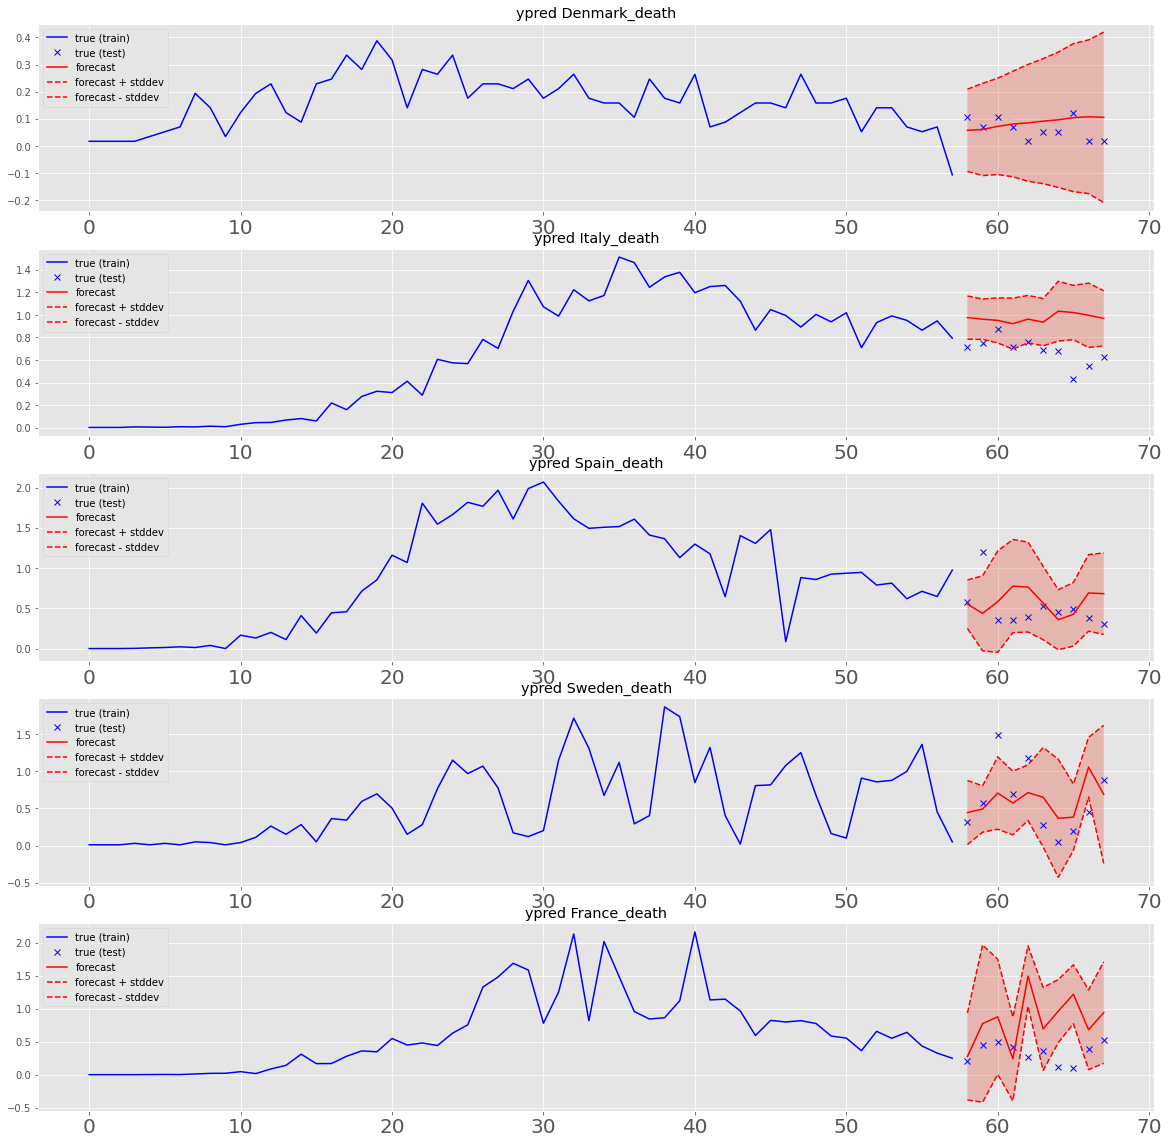

In [0]:
fig, axs = plt.subplots(nf_data,1, figsize=(20, 20))
#fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(nf_data):
    
  
  Chooseplot = i+1
  if (Chooseplot==1):
    q=y_pred_1
  elif (Chooseplot==2):
    q=y_pred_2
  elif (Chooseplot==3):
    q=y_pred_3
  elif (Chooseplot==4):
    q=y_pred_4
  elif (Chooseplot==5):
    q=y_pred_5
  

  q_mean = q.mean(axis=0).reshape(-1,)
  q_std = q.std(axis=0).reshape(-1,)
  y_pred_025 = q_mean - 1.96*q_std
  y_pred_975 = q_mean + 1.96*q_std
  y_pred_mean = q_mean

  axs[i].plot(ix_train, y_train[:, Chooseplot-1], "b-")
  axs[i].plot(ix_test, y_test[:, Chooseplot-1], "bx")
  axs[i].plot(ix_test, y_pred_mean[-N_test:], "r-")
  axs[i].plot(ix_test, y_pred_025[-N_test:], "r--")
  axs[i].plot(ix_test, y_pred_975[-N_test:], "r--")
  axs[i].fill_between(ix_test, y_pred_025, y_pred_975, alpha=0.3)
  axs[i].legend(["true (train)","true (test)","forecast","forecast + stddev","forecast - stddev"])

  if(Chooseplot==1):
    plotname='Denmark_death'
  elif(Chooseplot==2):
    plotname='Italy_death'
  elif(Chooseplot==3):
    plotname='Spain_death'
  elif(Chooseplot==4):
    plotname='Sweden_death'
  elif(Chooseplot==5):
    plotname='France_death'
  

  axs[i].set_title("ypred "+ plotname)
 

From the predictions we again see that there is a large uncertianty in the predictions, and that they differ from the true points. The addition of the google-data did not seem to have an effect on prediction-strength.

Inspecting traceplot for google data (stations and workplaces) coefficient.

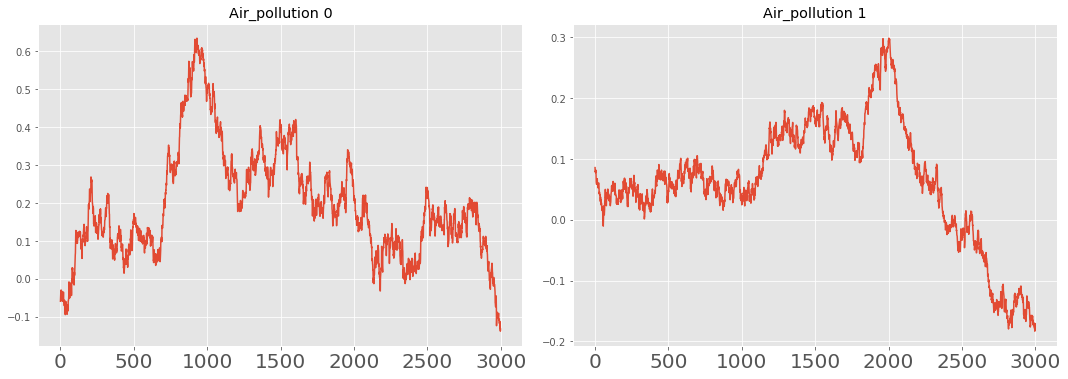

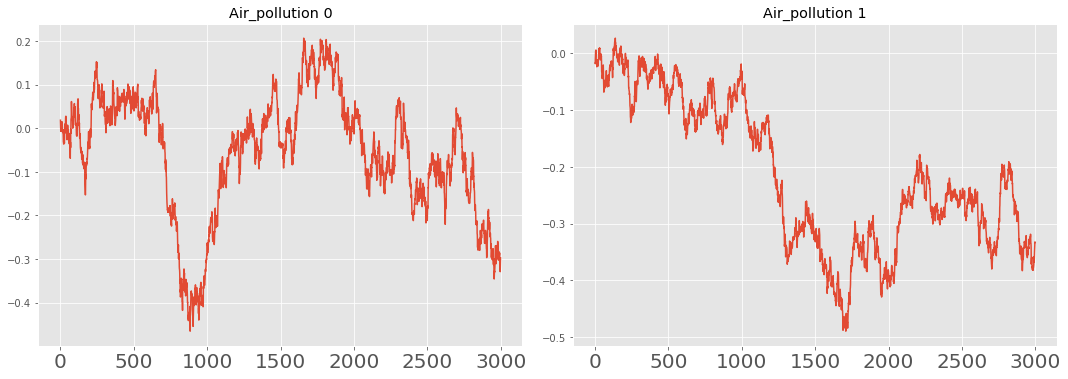

In [0]:

plt.figure(figsize=(15,10))
for i in range(2):
    ax=plt.subplot(2,2,i+1)
    plt.plot(pd.DataFrame(hmc_samples['G_stations'][:,i]))
    
    plt.title("Air_pollution "+str(i))
    #plt.setp(ax.get_xticklabels(), rotation=45)    
plt.tight_layout()
plt.show(ax)

plt.figure(figsize=(15,10))
for i in range(2):
    ax=plt.subplot(2,2,i+1)
    plt.plot(pd.DataFrame(hmc_samples['G_workplaces'][:,i]))
    
    plt.title("Air_pollution "+str(i))
    #plt.setp(ax.get_xticklabels(), rotation=45)    
plt.tight_layout()
plt.show(ax)




From the trace-plots we again note that the variables have not converged to a clear solution, indicating that the model might benefit from further training, or retuning of the MCMC algorithm.

Calculating MSE for the models:

In [0]:
from sklearn.metrics import mean_squared_error

#calculating mean of predictions for each timeseries
mean_preds_1_M4=y_pred_1.mean(axis=0).reshape(-1,) 
mean_preds_2_M4=y_pred_2.mean(axis=0).reshape(-1,)
mean_preds_3_M4=y_pred_3.mean(axis=0).reshape(-1,)
mean_preds_4_M4=y_pred_4.mean(axis=0).reshape(-1,)
mean_preds_5_M4=y_pred_5.mean(axis=0).reshape(-1,)

# calulating MSE for each timeseries on the test set
MSE1_M4=mean_squared_error(y_test.T[[0][0]], mean_preds_1_M4)
MSE2_M4=mean_squared_error(y_test.T[[1][0]], mean_preds_2_M4)
MSE3_M4=mean_squared_error(y_test.T[[2][0]], mean_preds_3_M4)
MSE4_M4=mean_squared_error(y_test.T[[3][0]], mean_preds_4_M4)
MSE5_M4=mean_squared_error(y_test.T[[4][0]], mean_preds_5_M4) 

# calculating the average of time series MSE, finding estimate of model MSE
model_avg_MSE_M4 = np.mean([MSE1_M4,MSE2_M4,MSE3_M4,MSE4_M4,MSE5_M4])
model_avg_MSE_M4

0.15793211816468472

The model performance has not been increased.

# MSE and OECD-weights exploration

In [0]:
#Land I model I MSE
MSE_data = pd.DataFrame([['Denmark','M1',MSE1_M1],
                         ['Denmark','M2',MSE1_M2],
                         ['Denmark','M3',MSE1_M3],
                         ['Denmark','M4',MSE1_M4],
                         ['Italy','M1',MSE2_M1],
                         ['Italy','M2',MSE2_M2],
                         ['Italy','M3',MSE2_M3],
                         ['Italy','M4',MSE2_M4],
                         ['Spain','M1',MSE3_M1],
                         ['Spain','M2',MSE3_M2],
                         ['Spain','M3',MSE3_M3],
                         ['Spain','M4',MSE3_M4],
                         ['Sweden','M1',MSE4_M1],
                         ['Sweden','M2',MSE4_M2],
                         ['Sweden','M3',MSE4_M3],
                         ['Sweden','M4',MSE4_M4],
                         ['France','M1',MSE5_M1],
                         ['France','M2',MSE5_M2],
                         ['France','M3',MSE5_M3],
                         ['France','M4',MSE5_M4],
                         ['All','M1',model_avg_MSE_M1],
                         ['All','M2',model_avg_MSE_M2],
                         ['All','M3',model_avg_MSE_M3],
                         ['All','M4',model_avg_MSE_M4]
                         ],columns=['Country','Model','MSE'])


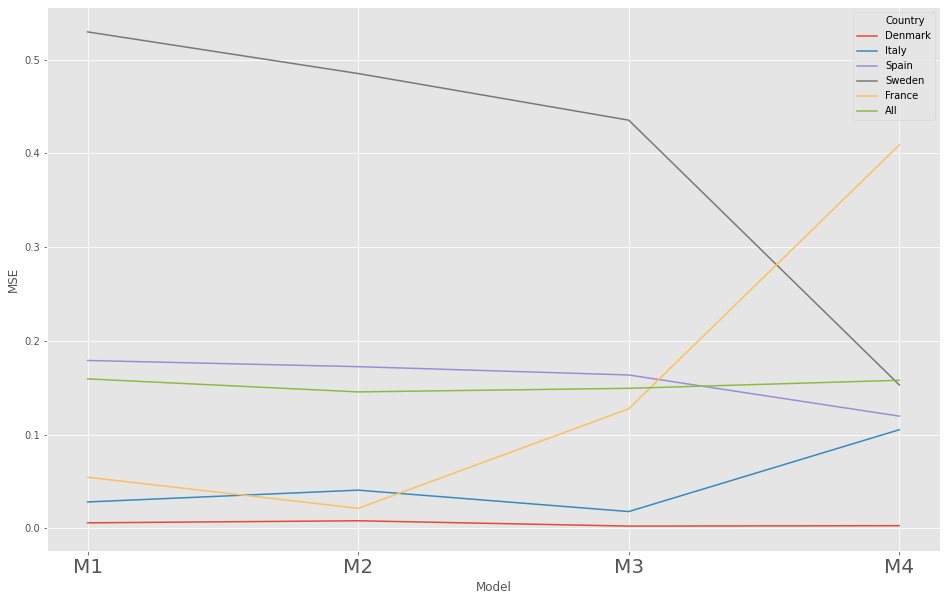

In [0]:
sns.lineplot('Model','MSE',hue='Country',data=MSE_data)

In the plot above we have plotted the MSE values across models for all the countries. We generally see that extending the models does not have a universal effect on MSE for predicting values for each country. For all extensions it is the case that some countries will be predicted with more precision and others with less precision. And there is no general tendency (green line)  towards better predictions when adding model complexity. 

We calculate the mean of the coefficient for each OECD-variable, as configured in the final model. We then plot these coefficients together and assess which of the variable - based on the model - has most impact on COVID-19 morbidity. However since the model performance did not improve when using the google data, it is likely that these varibles are insignicant, and conclusions should be drawn (very) carefully.

In [0]:
OECD_weight = pd.DataFrame([['Acute myocardial infarction',hmc_samples['Acute_myocardial_infarction'][:,:].mean().item()],
                            ['Chronic obstructive Pulmonary diseases',hmc_samples['Chronic_obstructive_Pulmonary_diseases'][:,:].mean().item()],
                            ['Diabetes mellitus',hmc_samples['Diabetes_mellitus'][:,:].mean().item()],
                            ['Diseases of the respiratory system',hmc_samples['Diseases_of_the_respiratory_system'][:,:].mean().item()],
                            ['Influenza',hmc_samples['Influenza'][:,:].mean().item()],
                            ['Ischaemic heart diseases',hmc_samples['Ischaemic_heart_diseases'][:,:].mean().item()],
                            ['Pneumonia',hmc_samples['Pneumonia'][:,:].mean().item()],
                            ['Population share 65-80 years',hmc_samples['Population__65_to_80_years_old'][:,:].mean().item()],
                            ['Population_share_above_80_years',hmc_samples['Population__80_years_old_and_over'][:,:].mean().item()],               
                            ['Air pollution',hmc_samples['Air_pollution'][:,:].mean().item()],
                            ['Rooms per person',hmc_samples['Rooms_per_person'][:,:].mean().item()],
                            ['Number of people per_household',hmc_samples['Number of people per household'][:,:].mean().item()],
                            ['Single person households',hmc_samples['Single person households'][:,:].mean().item()]],columns=['Variable','Weight'])



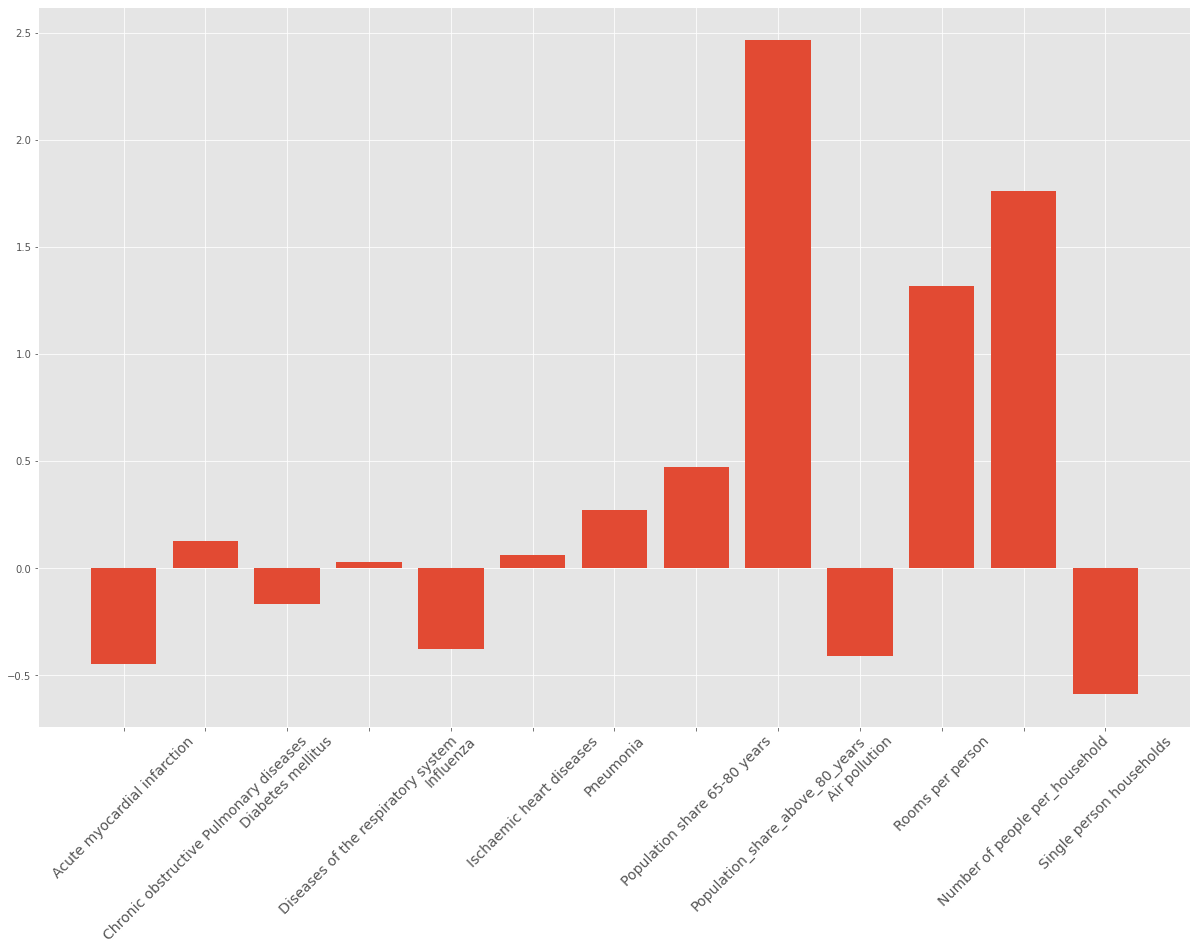

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(OECD_weight['Variable'],OECD_weight['Weight'])
plt.xticks(fontsize=14, rotation=45)
plt.show()

Based on the plot above we se that the coefficients for Population share above 80 years, Number of people per household and Rooms per person are the most influential variables regarding impact on COVID-19 morbidity. A bit surprising is that the some of the variables have negative coefficient - for example Air pollution - have negative coefficients, meaning that more of the variable results in fewer deaths. This is contrary to our initial expectation. This, along with the lack of performance increase when adding model complexity, makes us distrust the results of our models. 

# Conclusion

Since we did not observe any noticeable increase in performance when adding external variables to the model, one is compelled to conclude that these variables are not useful in determining the mortality of COVID-19. Since other research projects have shown the opposite, it might also be due to some of the modelling choices we made. The model we proposed is (for the sake of simplicity, and knowing we did not have a lot of data at hand) relying on simplistic linear relations, and we did not investigate whether there might exist non-linear relations which would improve model predictions. Additionally it might be the case that a sudden addition of many external covariates caused the model to overfit as the degrees of freedom for the model decreased drastically. The modelling approach might have been better when utilizing more data (whether it being longer time-series, or addition of countries), but unfortunately neither of these two were possible. Additionlly we saw from analysis of trace-plots that the higher complexity models (Model 3 and Model 4) did not converge to a satisfiable solution, as the posterior for several of the variables were still fluctuating (despite many iterations) - this might indicate an erroneous step-size (which however was tried exhaustively) or lack of number of iterations. It could also be the case that the true posterior is a highly complex distribution, which is naturally hard to infer. 